In [ ]:
!nvidia-smi

Mon May 22 19:51:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 31.9 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import cv2
import PIL
import imageio
from IPython.display import Image

from pprint import pprint

In [ ]:
def show_images(images):
  num_images = images.shape[0]
  num_rows = (num_images - 1 // 10)
  num_cols = 10
  fig = plt.figure(figsize=(num_rows * 10, num_cols * 10))

  for i in range(images.shape[0]):
      plt.subplot(num_rows, num_cols, i+1)
      plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()


def show_gif(images):
  filename = 'tmp.gif'

  _steps_outputs = tf.image.resize(steps_outputs, (256, 256))
  _steps_outputs = tf.cast(_steps_outputs * 127.5 + 127.5, tf.uint8).numpy()

  with imageio.get_writer(filename, mode='I') as writer:
    for image in _steps_outputs:
      writer.append_data(image)
      
  with open(filename, 'rb') as file:
      display(Image(file.read()))

## Zbiór danych

In [ ]:
train_ds, info = tfds.load('mnist', split='train', with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


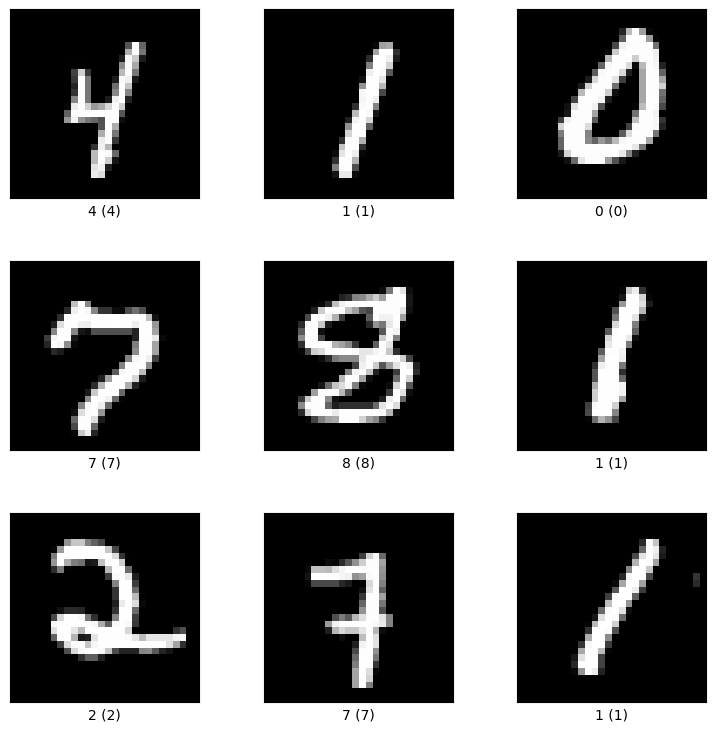

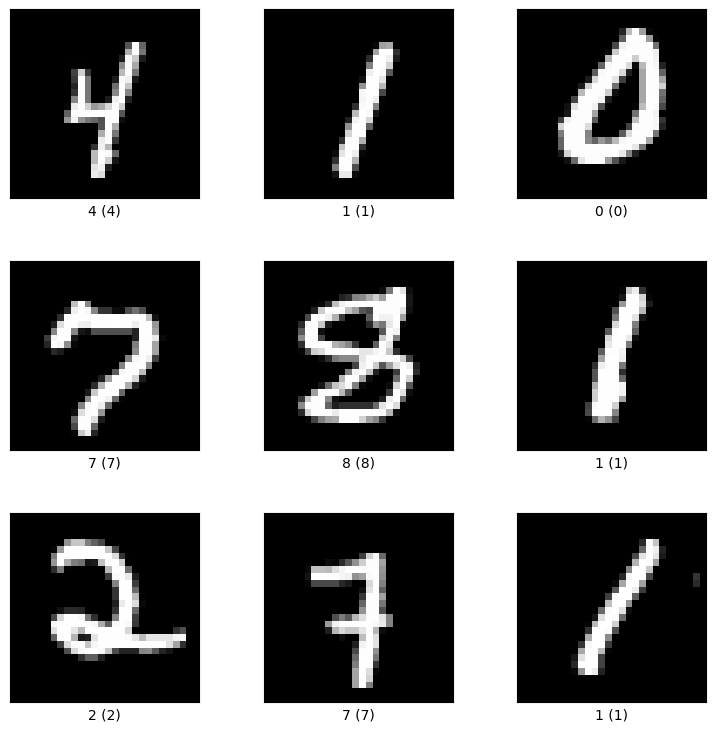

In [ ]:
tfds.show_examples(train_ds, info)

## Architektura neuronowa

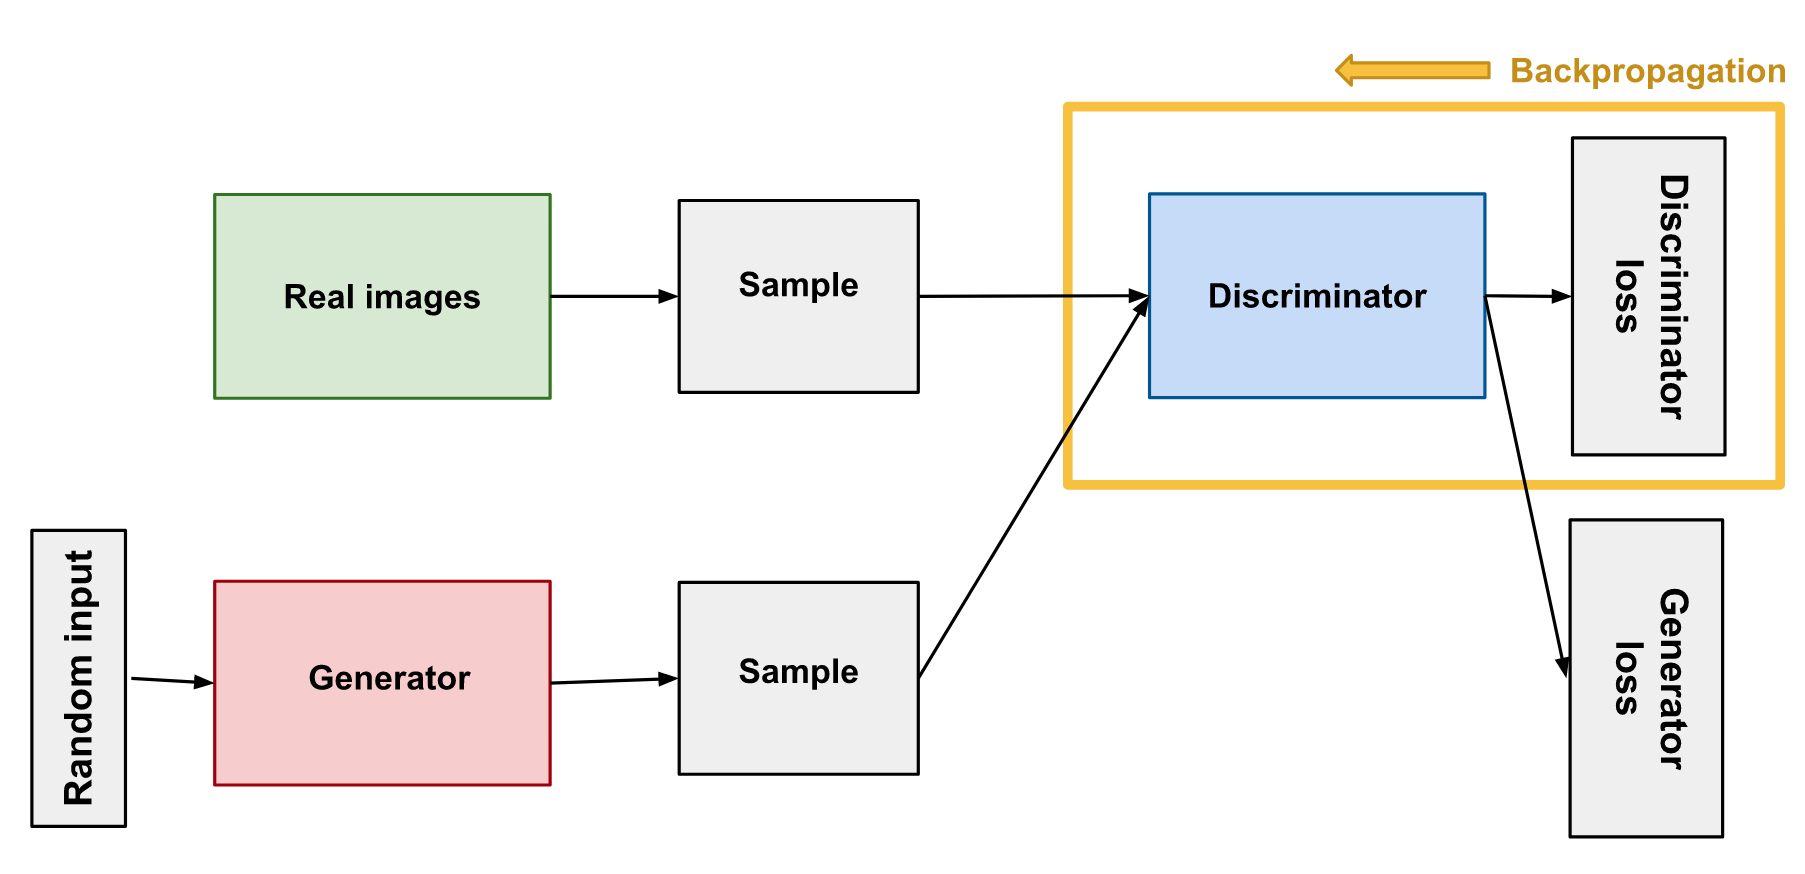

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def min_max_discriminator_loss(real_out, gen_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    gen_loss = bce(tf.zeros_like(gen_out), gen_out)
    return real_loss + gen_loss


def min_max_generator_loss(gen_out):
    return bce(tf.ones_like(gen_out), gen_out)

### Generator

W ogólności model generatora można matematycznie przedstawić jako funkcję:

$$G: \mathbb{R}^N \rightarrow \mathbb{R}^{H \times W}$$

Gdzie N to rozmiar danych wejściowycj (np. rozmiar szumu, z którego generujemy dane), a ${H \times W}$ to wysokość i szerokość generowanego obrazu.

A więc, model generatora na wejściu otrzymywać będzie pewien losowy wektor i przekształcać go będzie w dane o rozmiarze zgodnym z obrazami (w tym przypadku dla MNIST: 28 x 28 x 1).

In [ ]:
class Generator(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.model = tf.keras.Sequential([
        # flat      
        tf.keras.layers.Dense(7*7*256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape([7, 7, 256]),
        # conv without stride (7x7)
        tf.keras.layers.Conv2D(128, 5, 1, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # t_conv with stride (14x14)
        tf.keras.layers.Conv2DTranspose(128, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # conv without stride (14x14)
        tf.keras.layers.Conv2D(64, 5, 1, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # t_conv with stride (28x28)
        tf.keras.layers.Conv2DTranspose(32, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # conv without stride
        tf.keras.layers.Conv2D(1, 5, 1, 'same', activation='tanh')
    ])

  def call(self, noise, training):
    return self.model(noise, training)

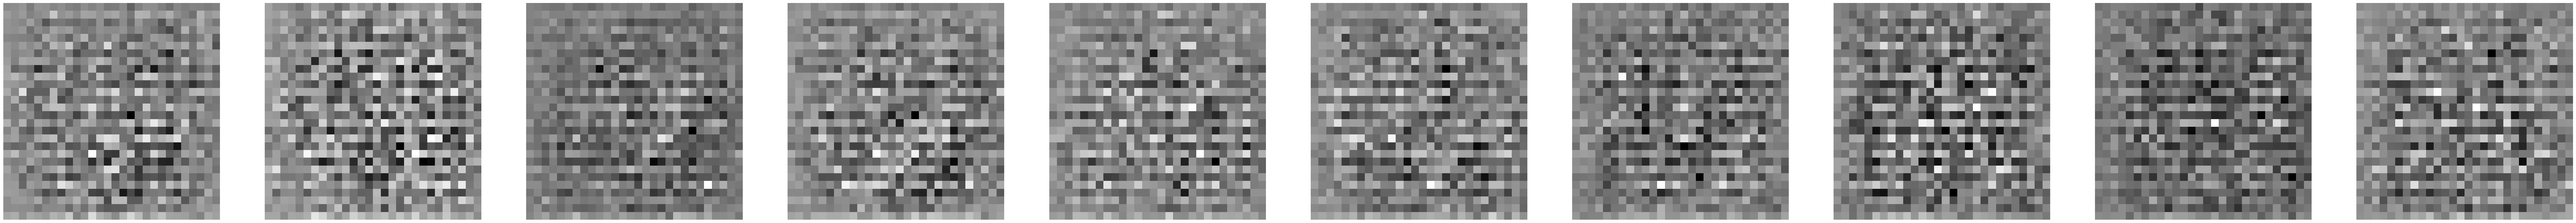

In [ ]:
generator = Generator()

dummy_input = tf.random.uniform([10, 32], -1, 1)
dummy_output = generator(dummy_input, False)

show_images(tf.clip_by_value(dummy_output, -1, 1))

### Dyskryminator

In [ ]:
class Discriminator(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.image_encoder = tf.keras.Sequential([
        # conv with stride (out = 14x14)
        tf.keras.layers.Conv2D(64, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        # conv with steide (out = 7x7)
        tf.keras.layers.Conv2D(128, 3, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        # flatten + hidden layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        # prediction (LOGITS!)
        tf.keras.layers.Dense(1)
    ])

  def call(self, images, training):
    return self.image_encoder(images, training)

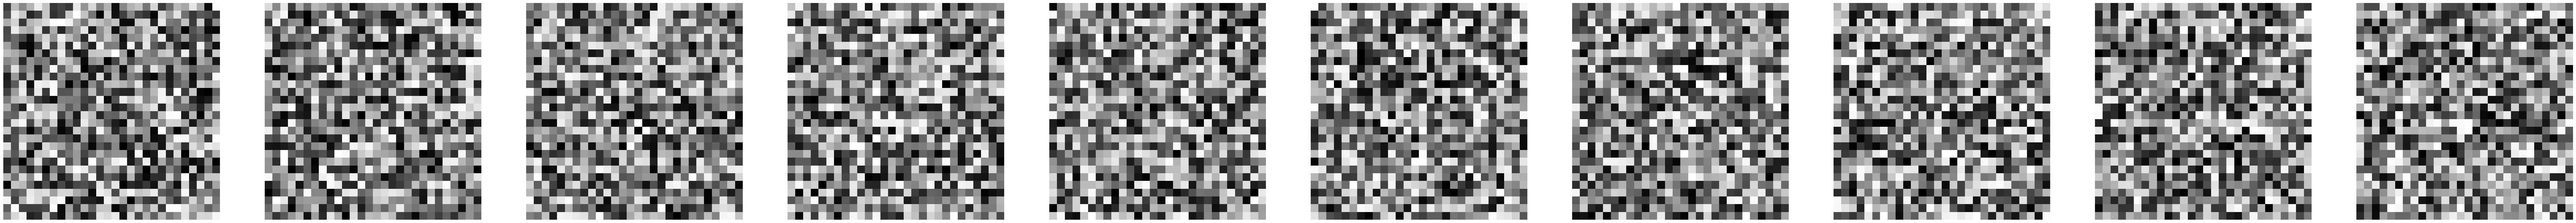

[[ 0.06066538]
 [ 0.12280349]
 [ 0.15127884]
 [ 0.08151459]
 [ 0.09594014]
 [ 0.03507359]
 [ 0.05074171]
 [-0.03140096]
 [ 0.05585265]
 [ 0.03136346]]


In [ ]:
discriminator = Discriminator()

dummy_input = tf.random.uniform([10, 28, 28, 1], -1, 1)
dummy_output = discriminator(dummy_input, False)

show_images(dummy_input)
print(dummy_output.numpy())

In [ ]:
class NoiseGenerator(tf.keras.layers.Layer):

  def __init__(self, distribution_size):
    super().__init__()
    self.distribution_size = distribution_size

  def call(self, size):
    return tf.random.uniform([size, self.distribution_size], -1, 1)

In [ ]:
def train_step_template(generator, discriminator, noise, d_optim, g_optim, d_loss_f, g_loss_f):

  @tf.function
  def _train_step_template(images, labels):
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      real_out = discriminator(images, True)
      gen_out = discriminator(generator(noise(tf.shape(labels)[0]), True), True)

      d_loss = d_loss_f(real_out, gen_out)
      g_loss = g_loss_f(gen_out)
    
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables + noise.trainable_variables)

    d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    g_optim.apply_gradients(zip(g_grads, generator.trainable_variables + noise.trainable_variables))
  
  return _train_step_template

In [ ]:
def gen_step_template(generator, noise):

  @tf.function
  def _gen_step_template(num_images):
    return generator(noise(num_images)) / 2 + 0.5

  return _gen_step_template

In [ ]:
def preprocess(batch):
  batch['image'] = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch['image'] = batch['image'] * 2 - 1
  return batch

def train(train_step, gen_step, epochs, batch_size):
  _train_ds = train_ds \
    .shuffle(5000) \
    .map(preprocess, num_parallel_calls=8) \
    .batch(batch_size) \
    .prefetch(4)
    
  for epoch in range(epochs):

    for batch in _train_ds:
      train_step(batch['image'], batch['label'])
    
    print('Epoch {0}/{1}'.format(epoch, epochs))

    images = gen_step(10)
    show_images(images)

Epoch 0/50


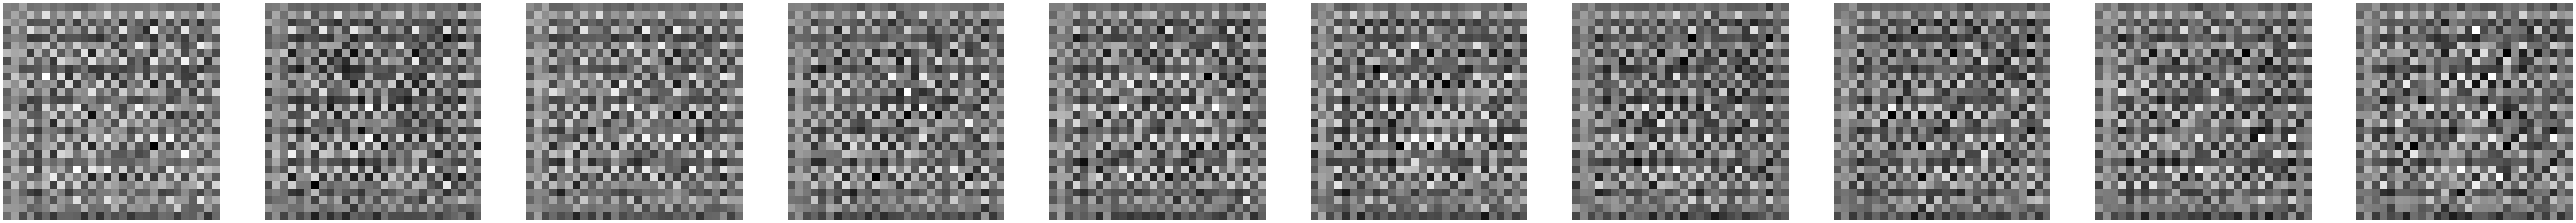

Epoch 1/50


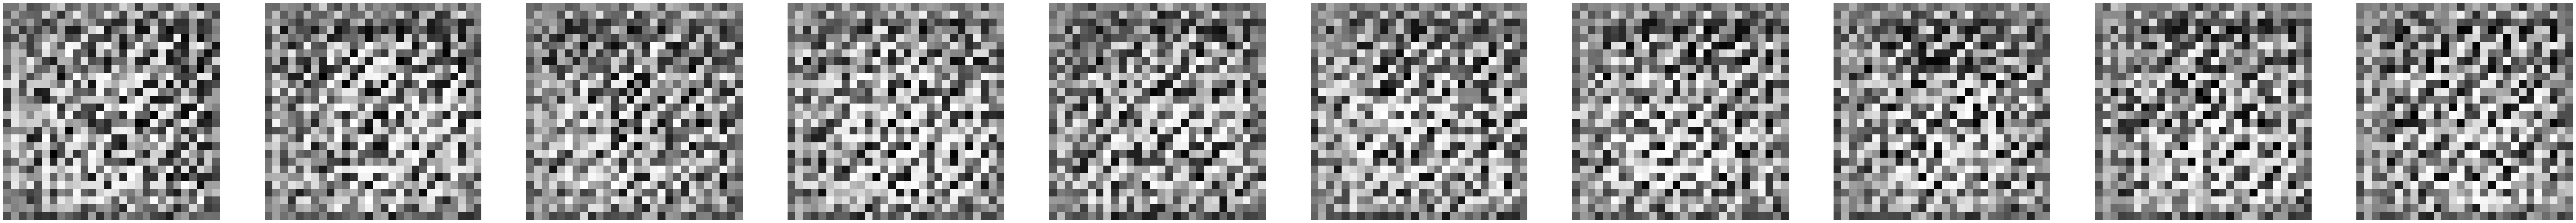

Epoch 2/50


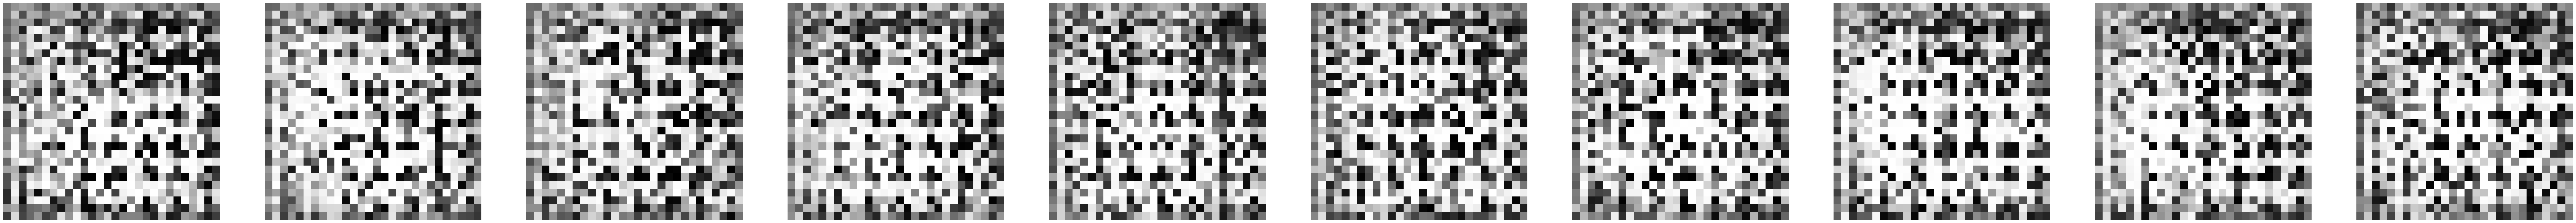

Epoch 3/50


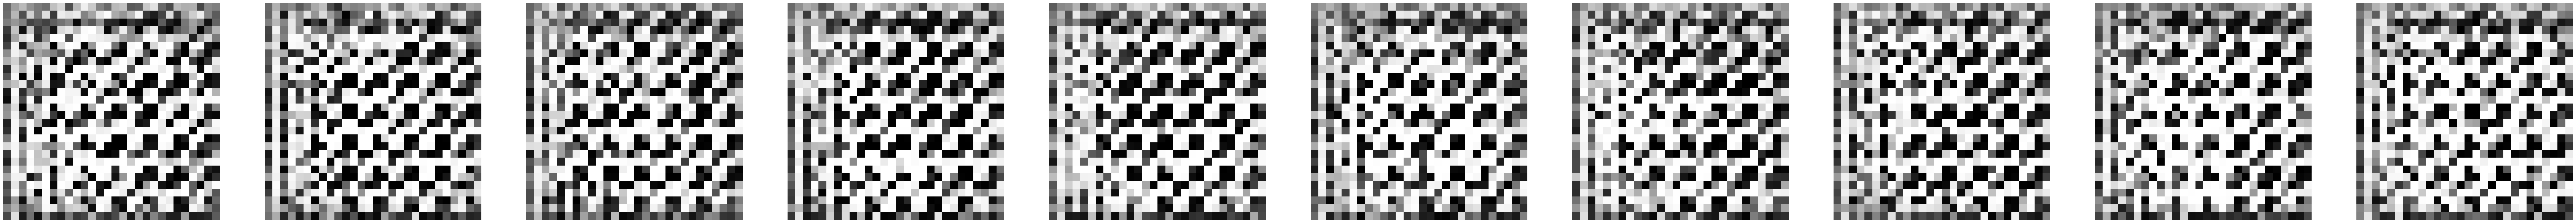

Epoch 4/50


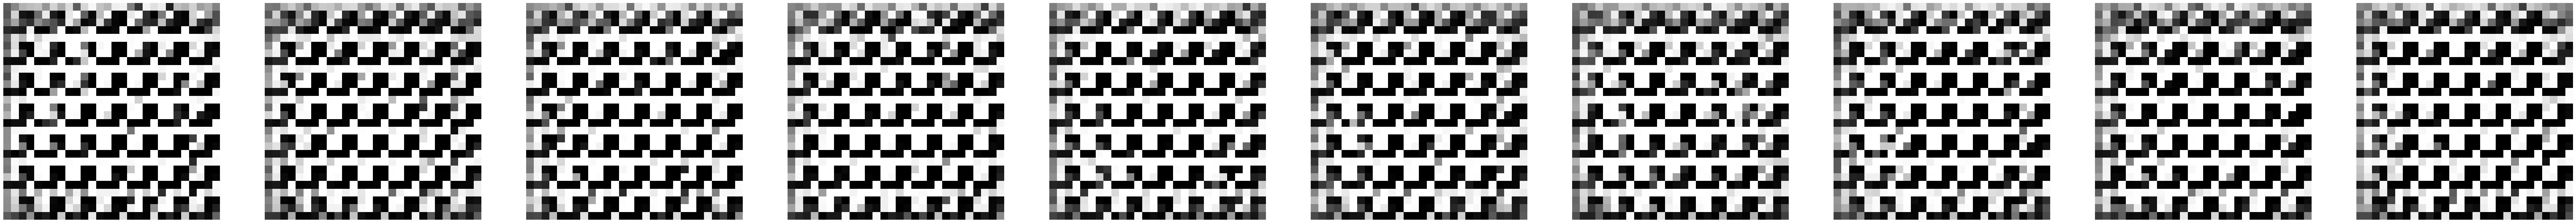

Epoch 5/50


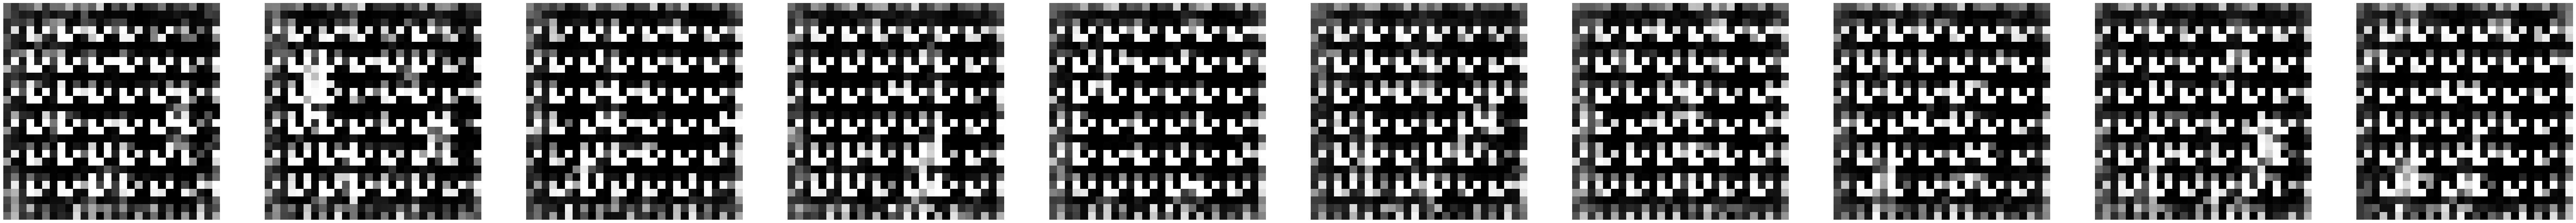

Epoch 6/50


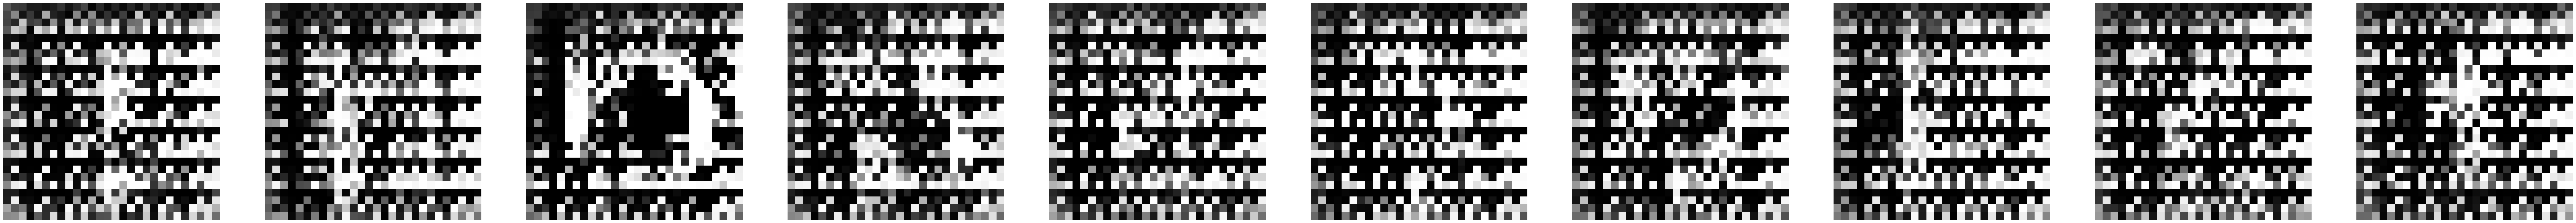

Epoch 7/50


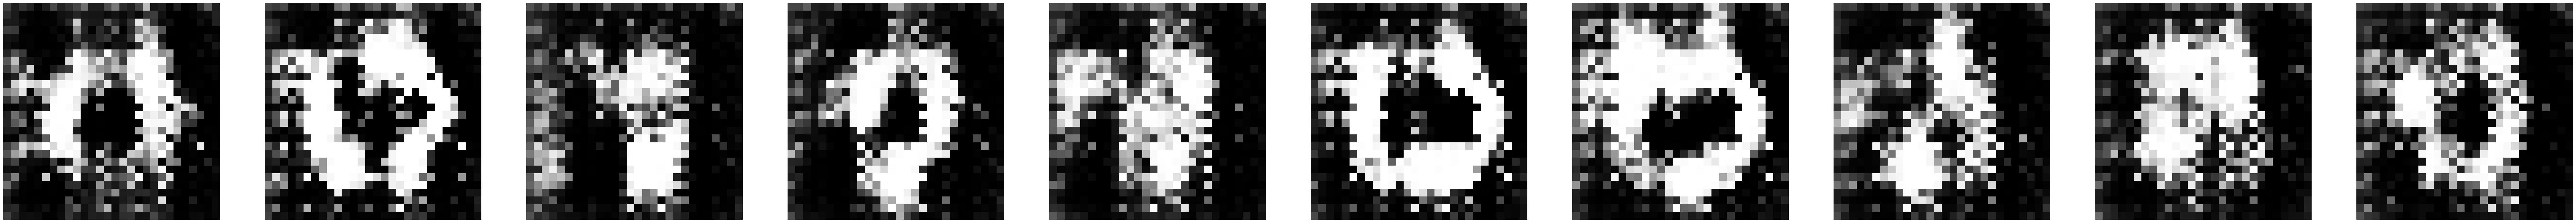

Epoch 8/50


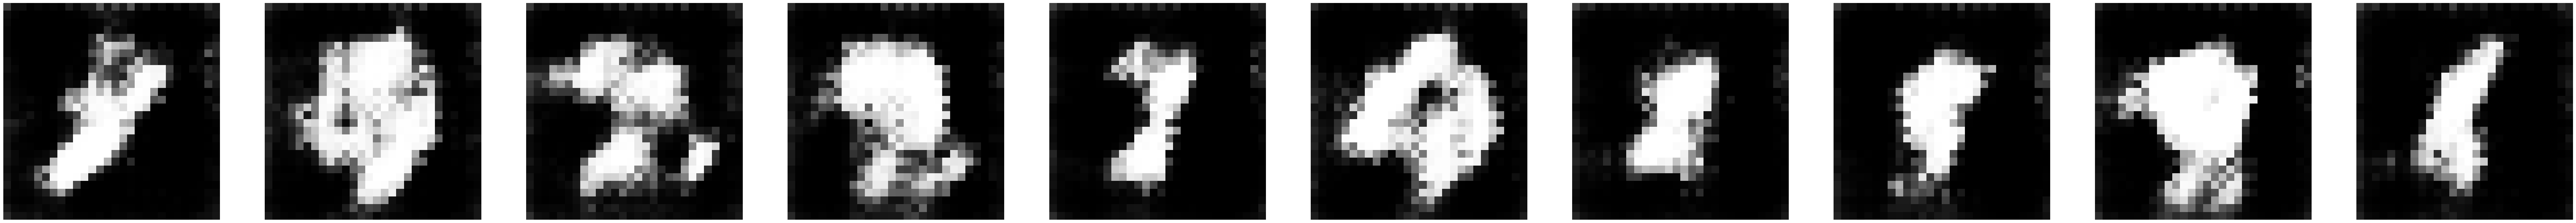

Epoch 9/50


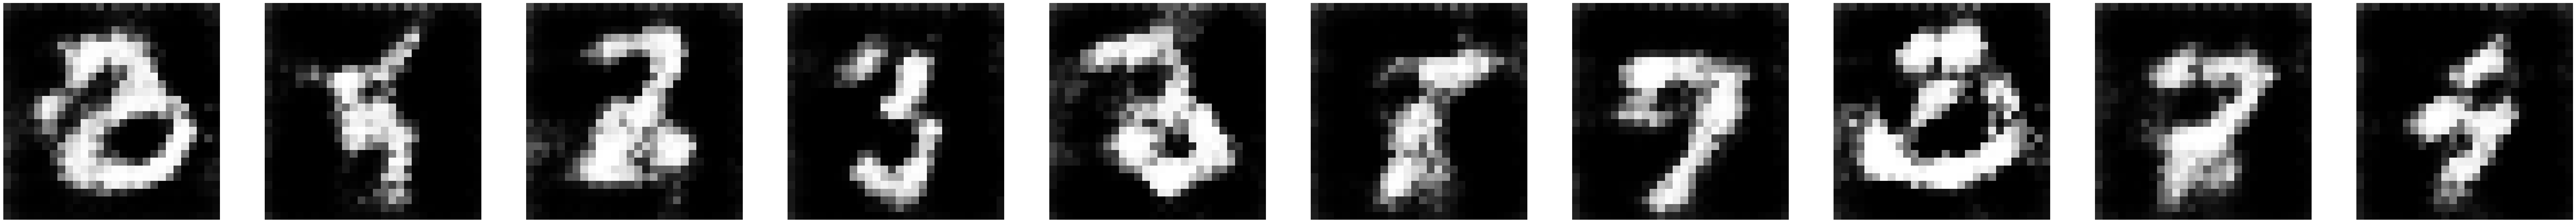

Epoch 10/50


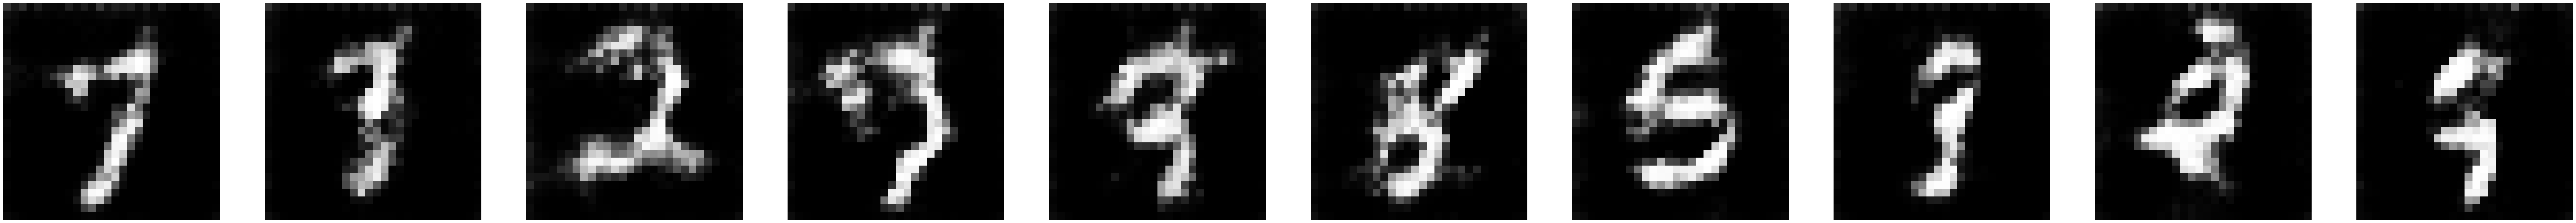

Epoch 11/50


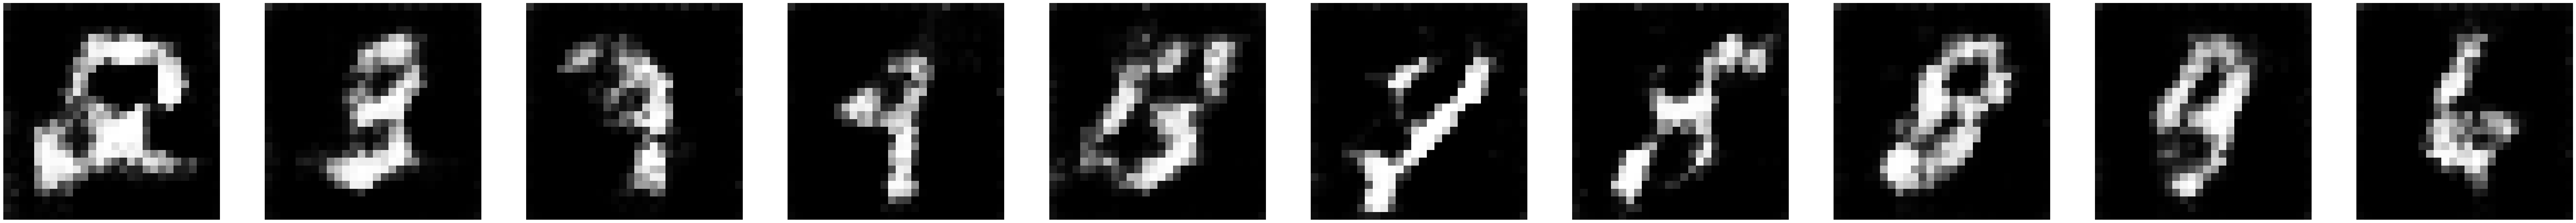

Epoch 12/50


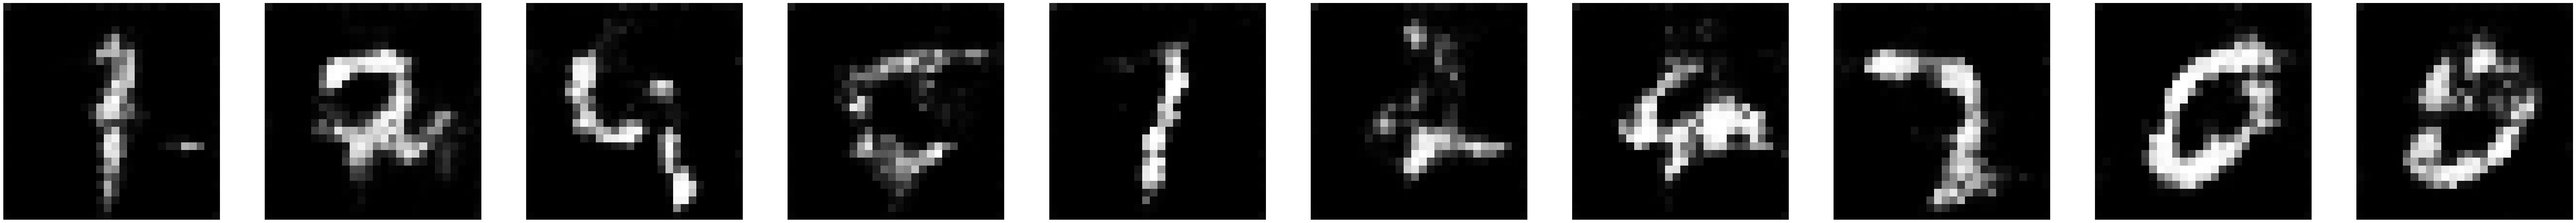

Epoch 13/50


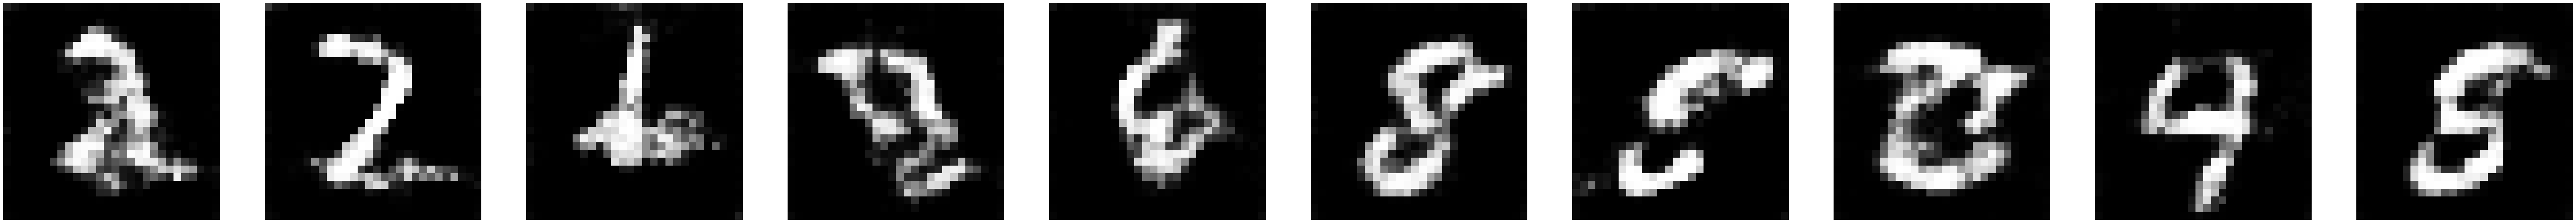

Epoch 14/50


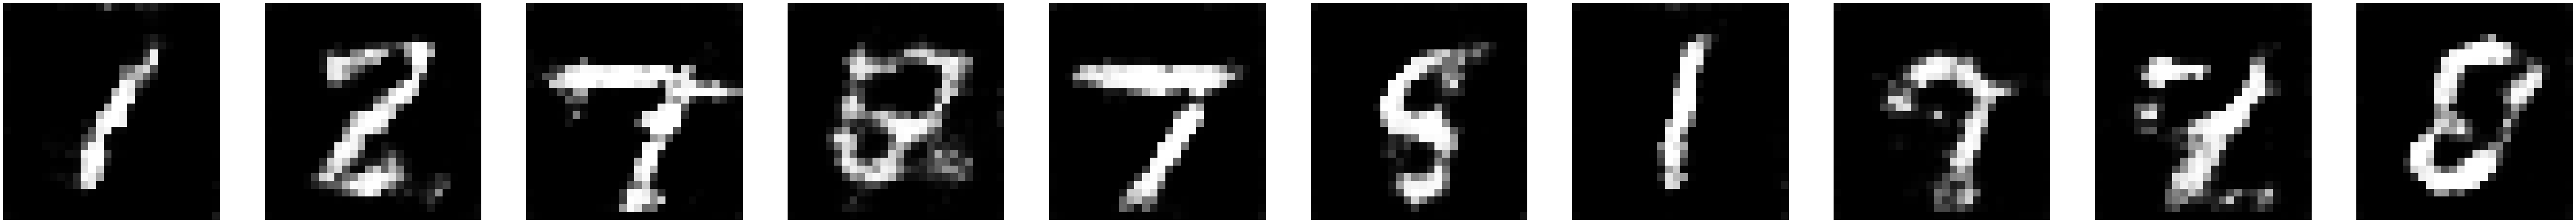

Epoch 15/50


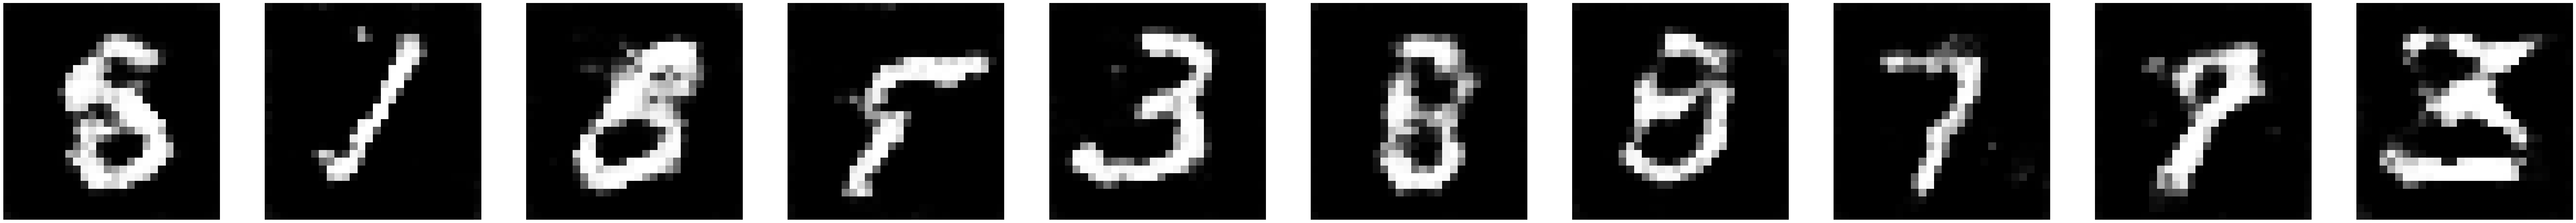

Epoch 16/50


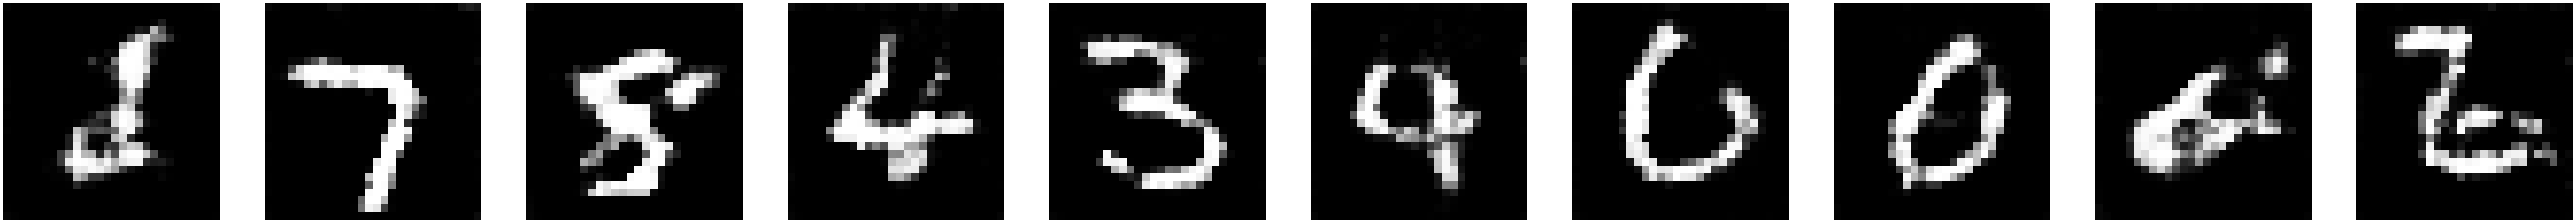

Epoch 17/50


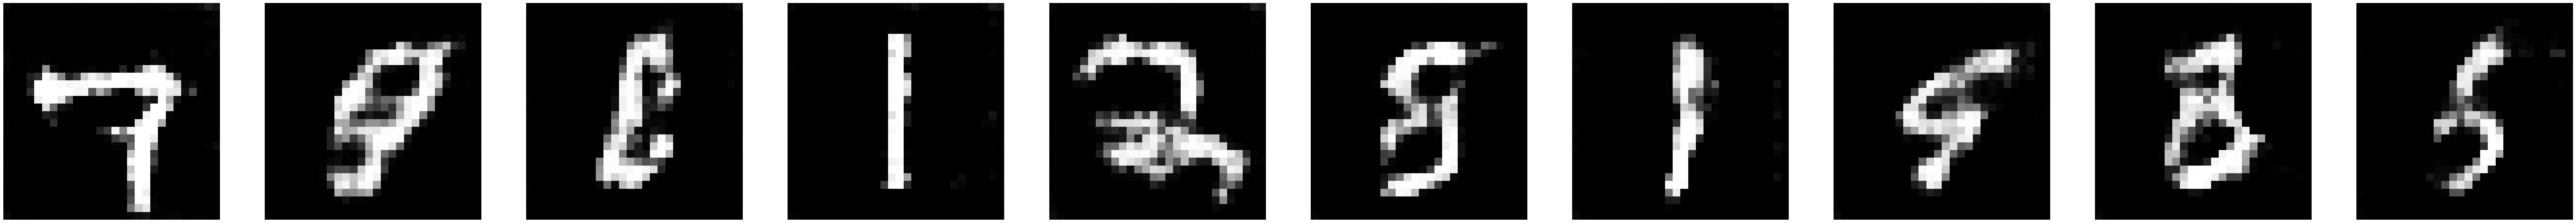

Epoch 18/50


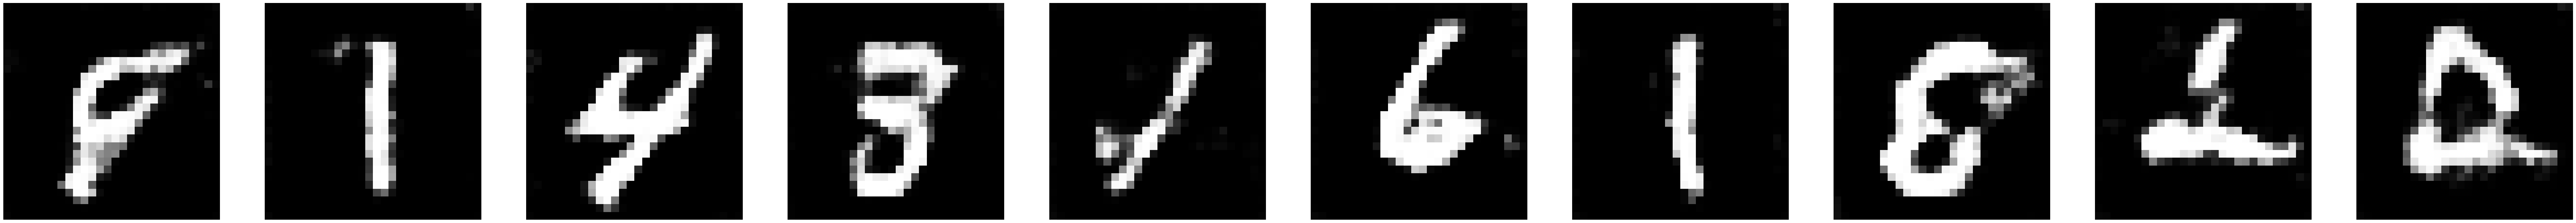

Epoch 19/50


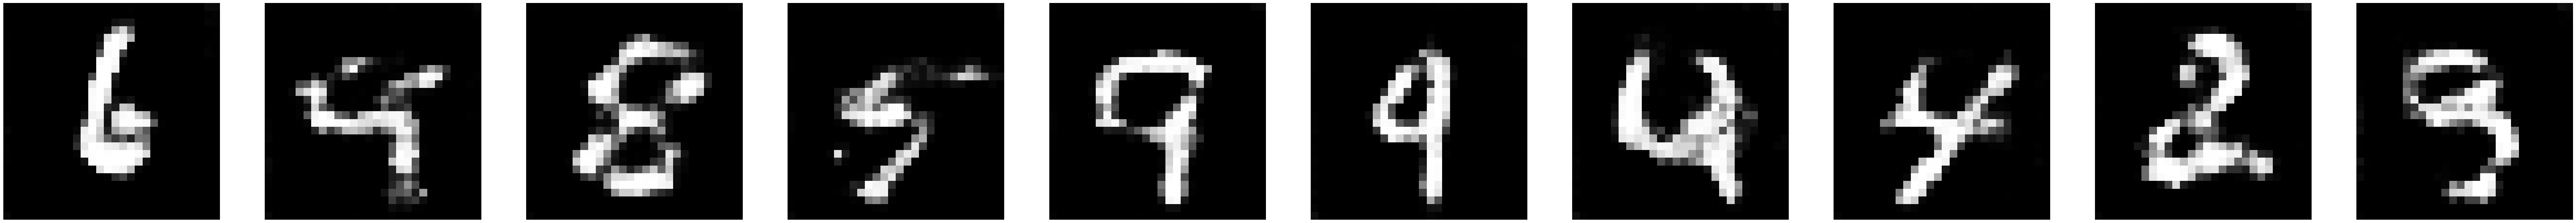

Epoch 20/50


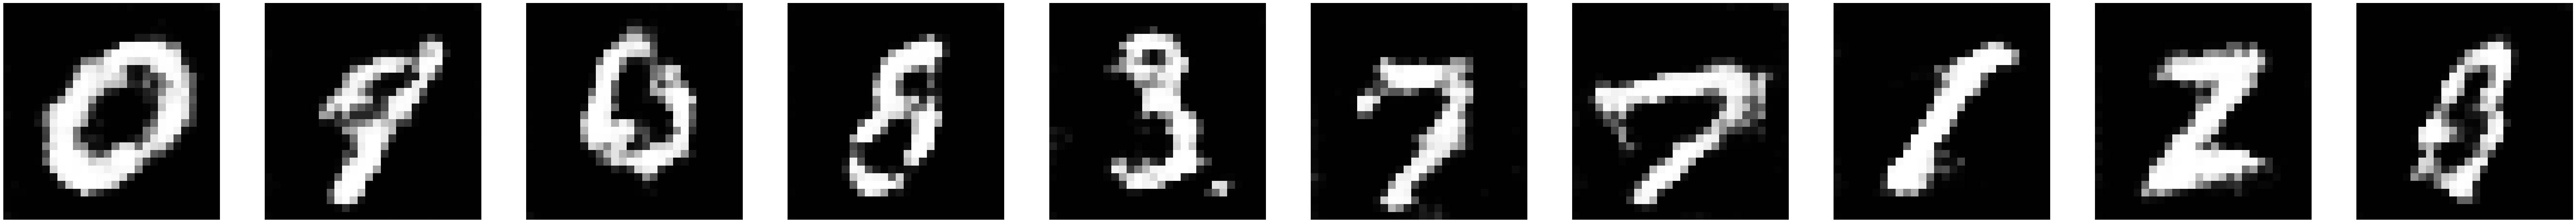

Epoch 21/50


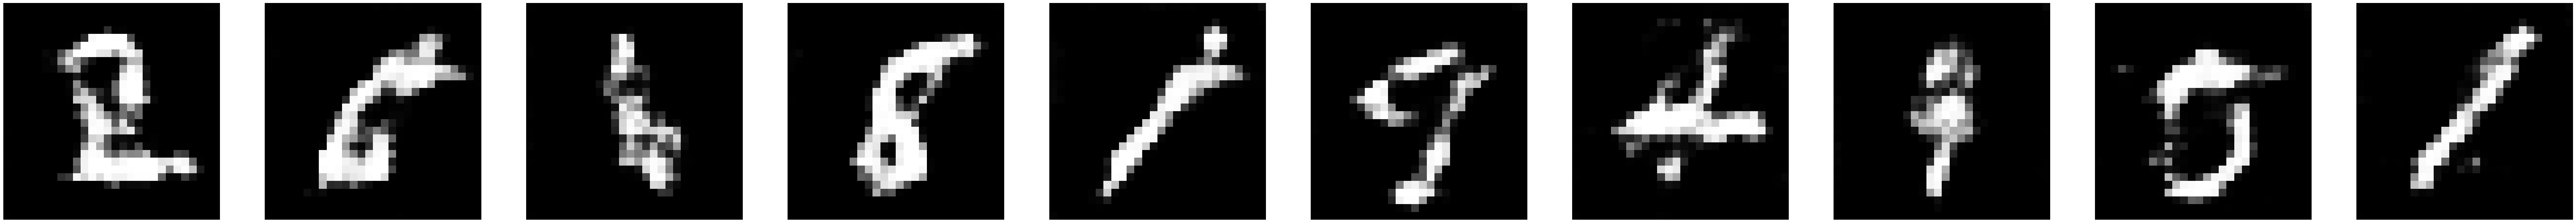

Epoch 22/50


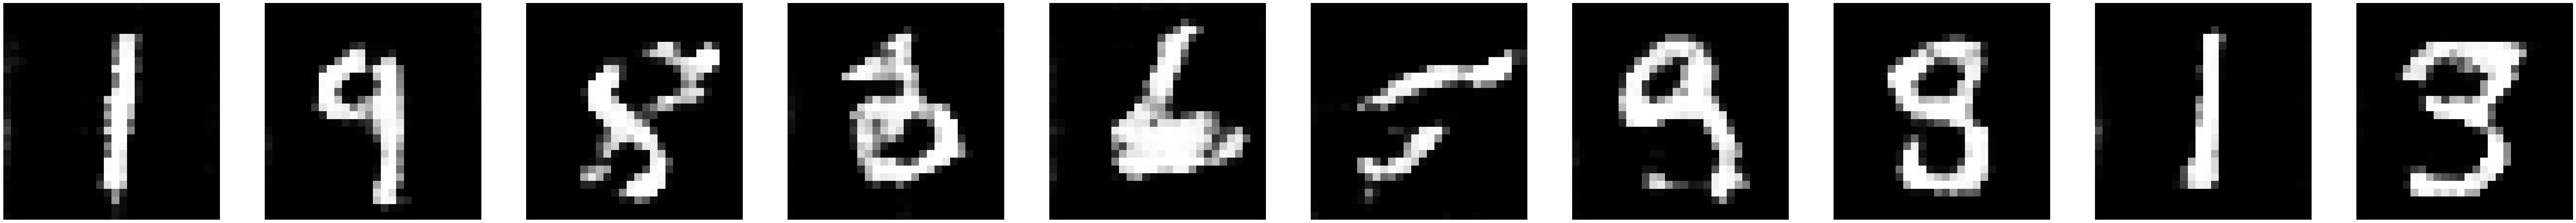

Epoch 23/50


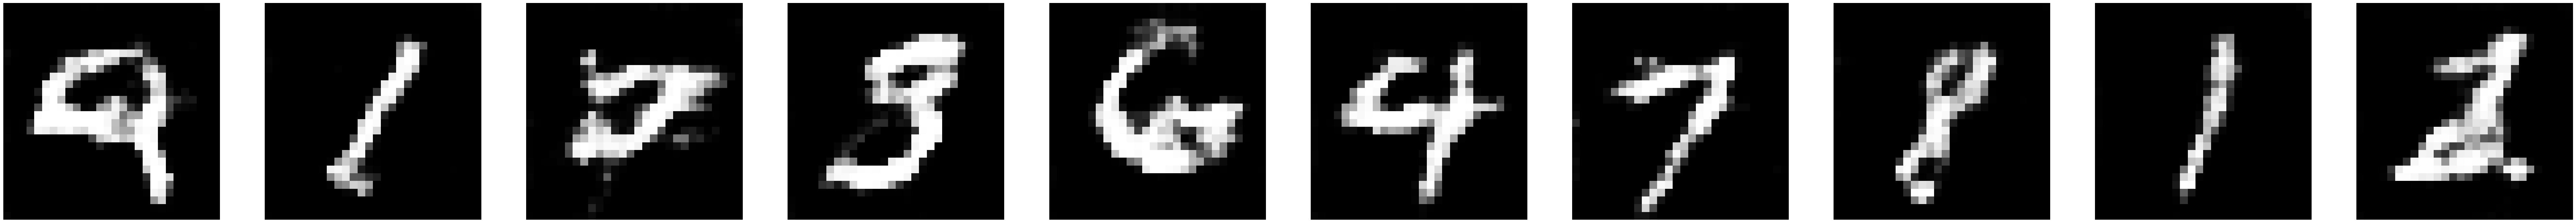

Epoch 24/50


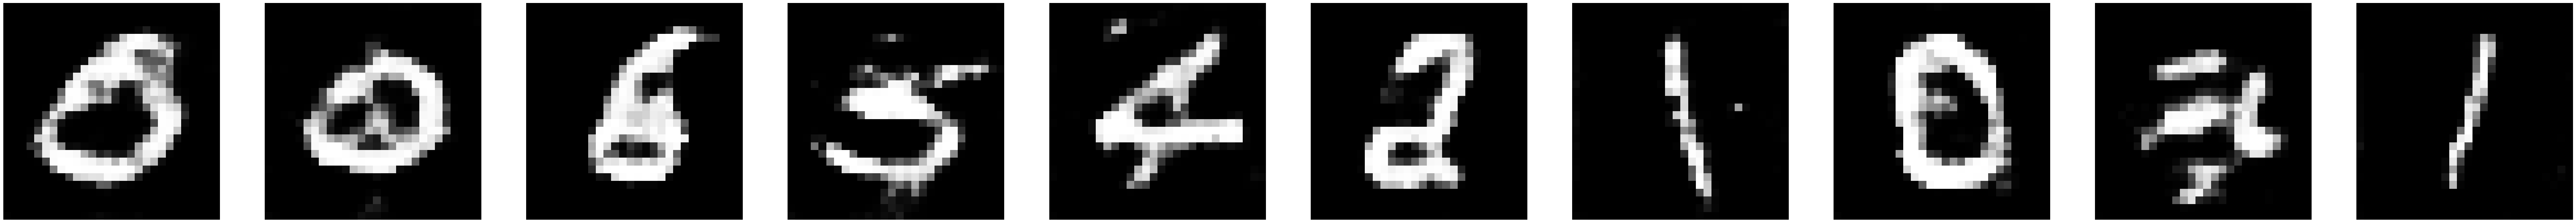

Epoch 25/50


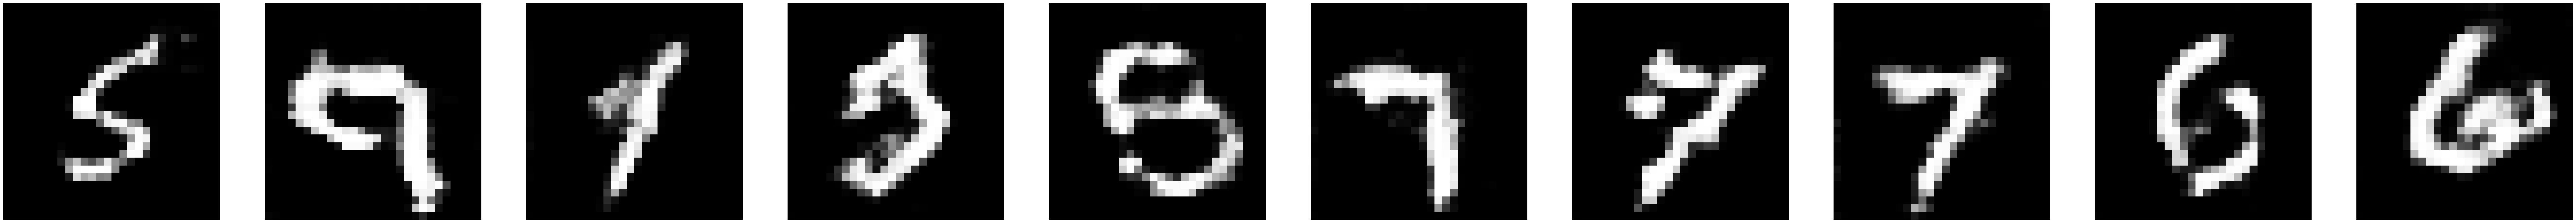

Epoch 26/50


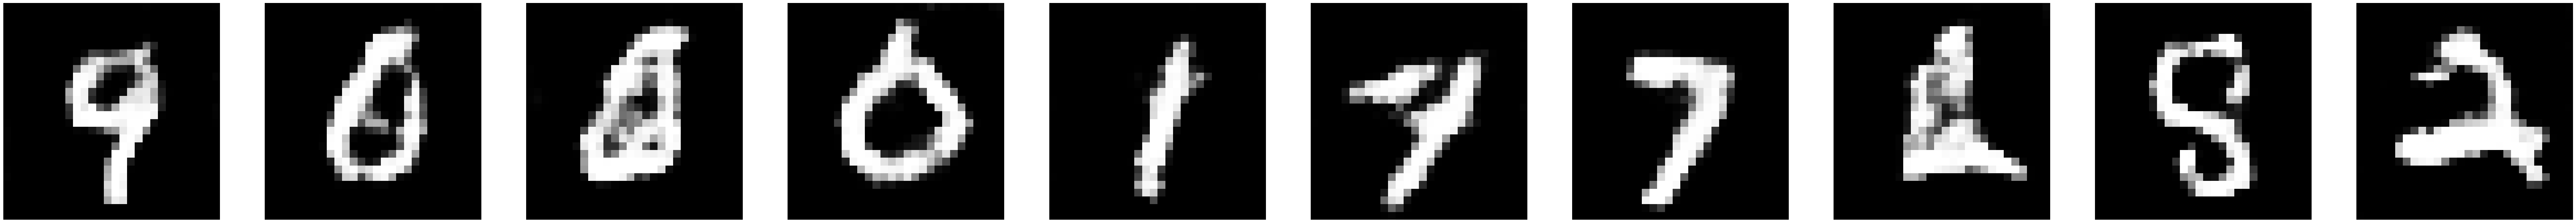

Epoch 27/50


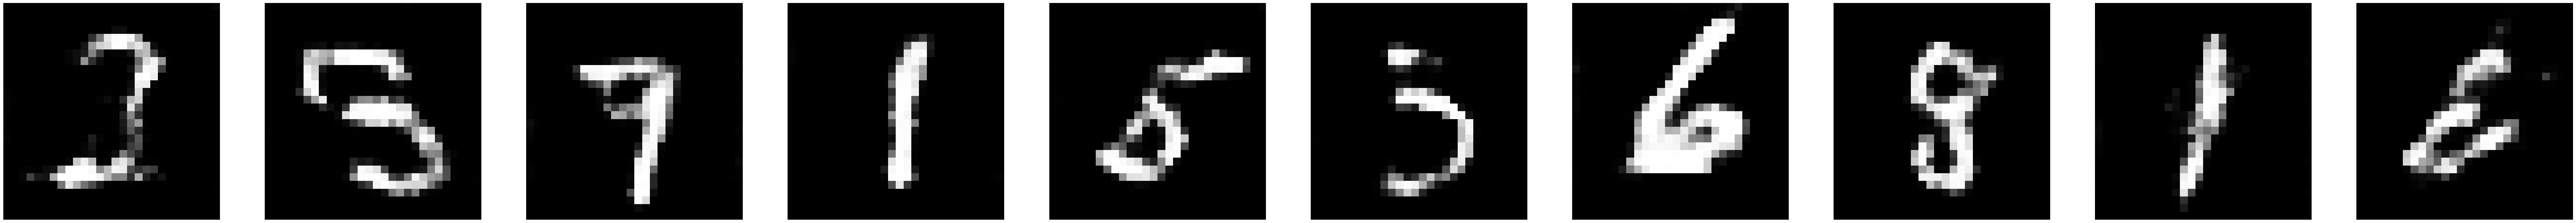

Epoch 28/50


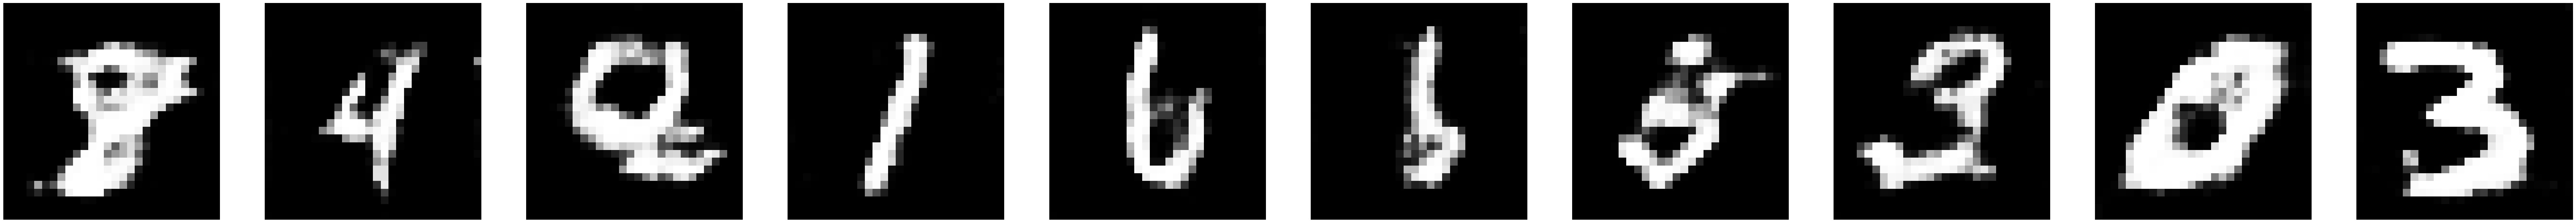

Epoch 29/50


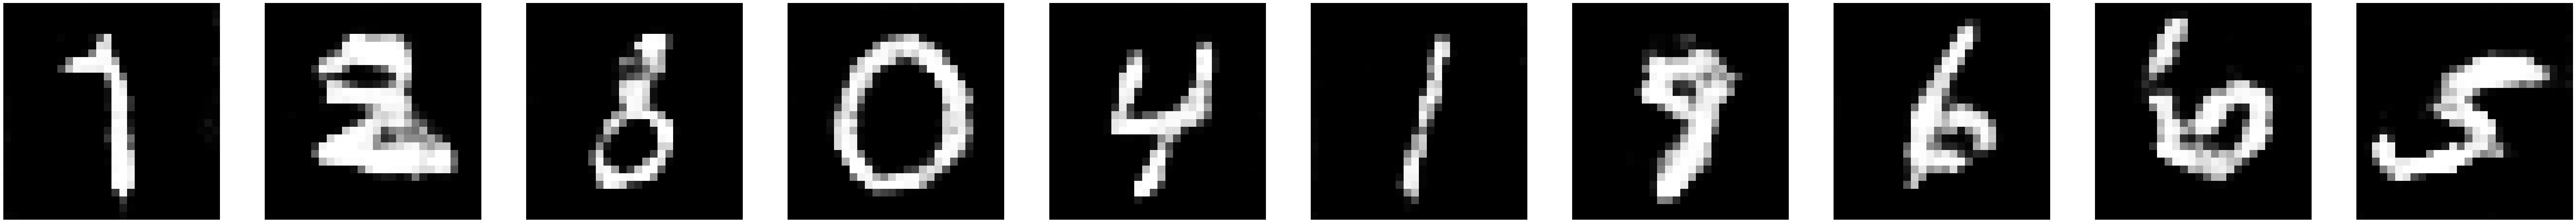

Epoch 30/50


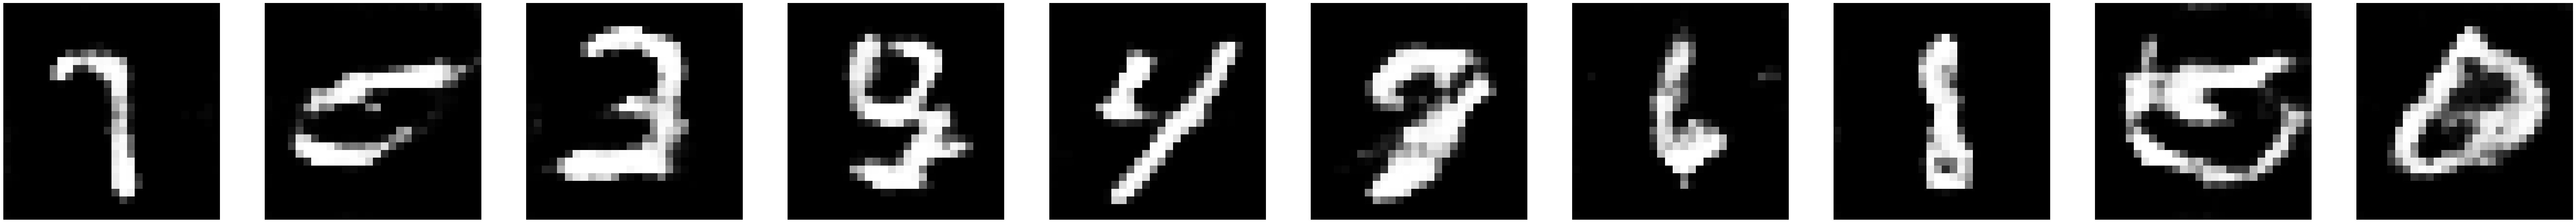

Epoch 31/50


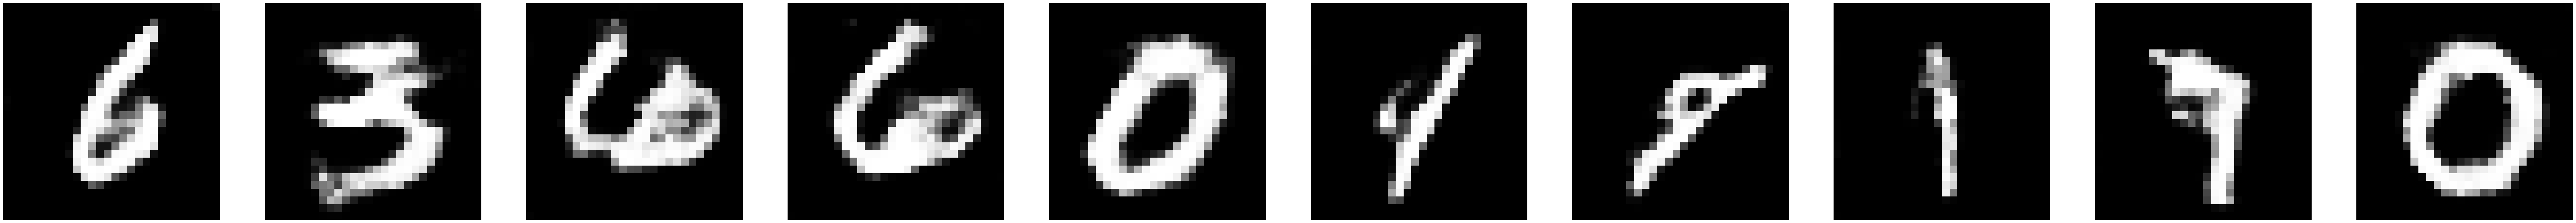

Epoch 32/50


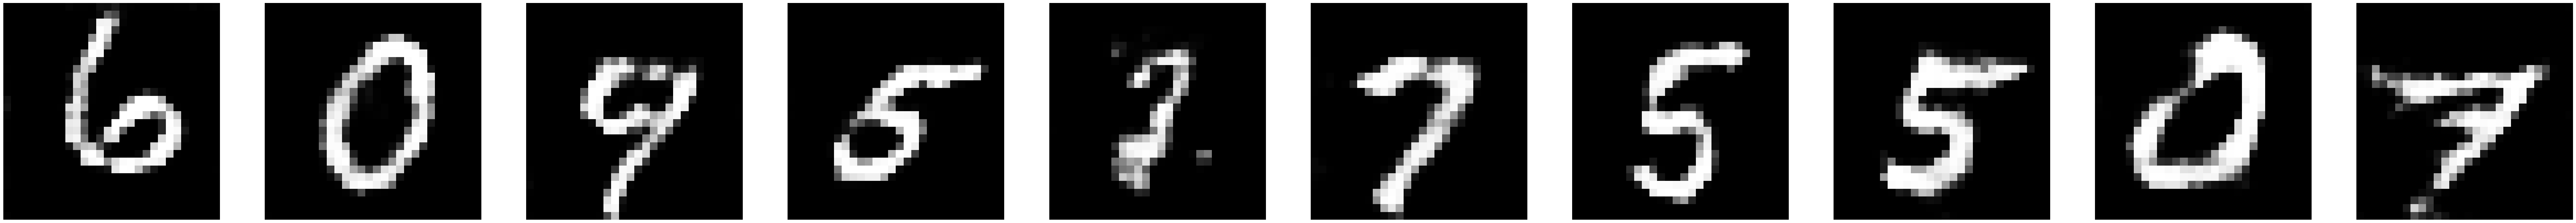

Epoch 33/50


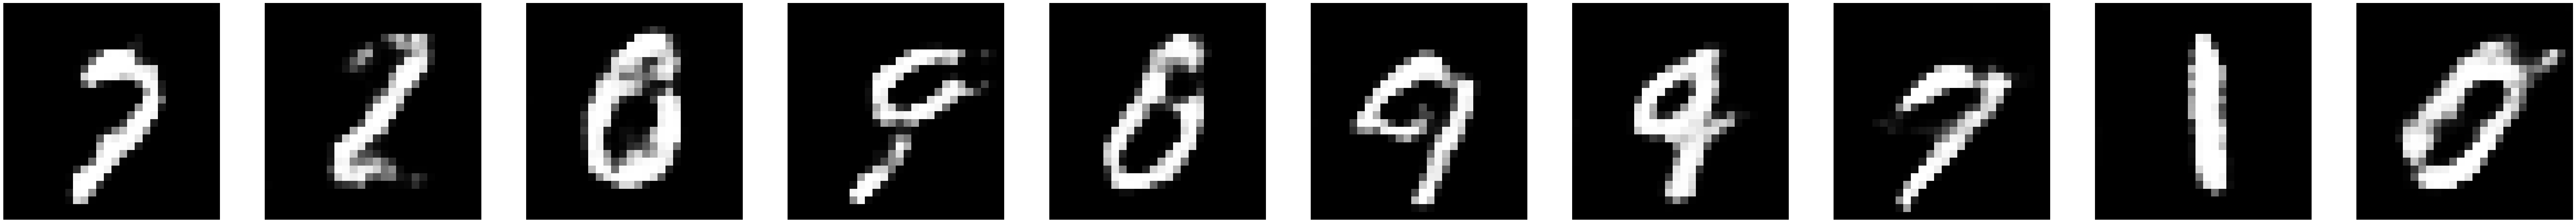

Epoch 34/50


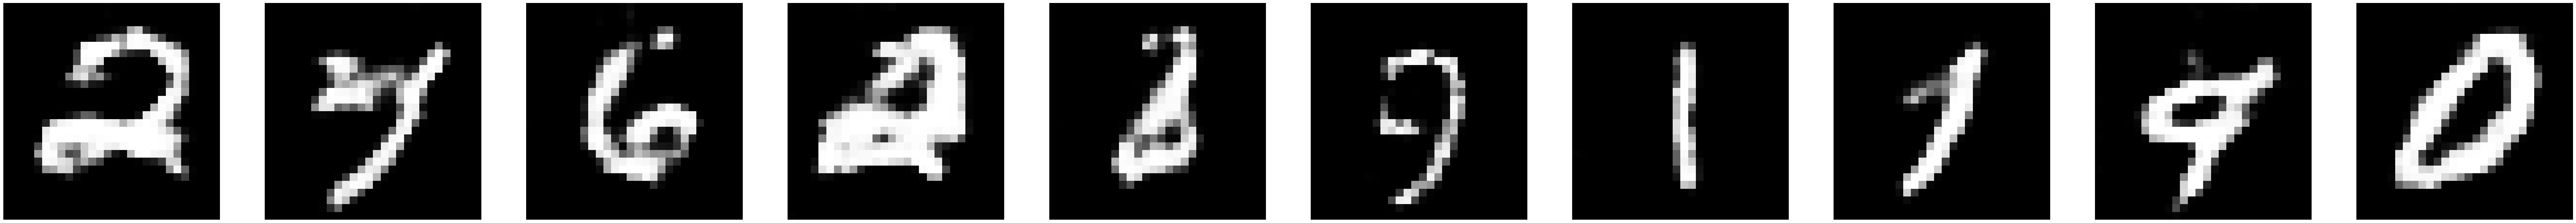

Epoch 35/50


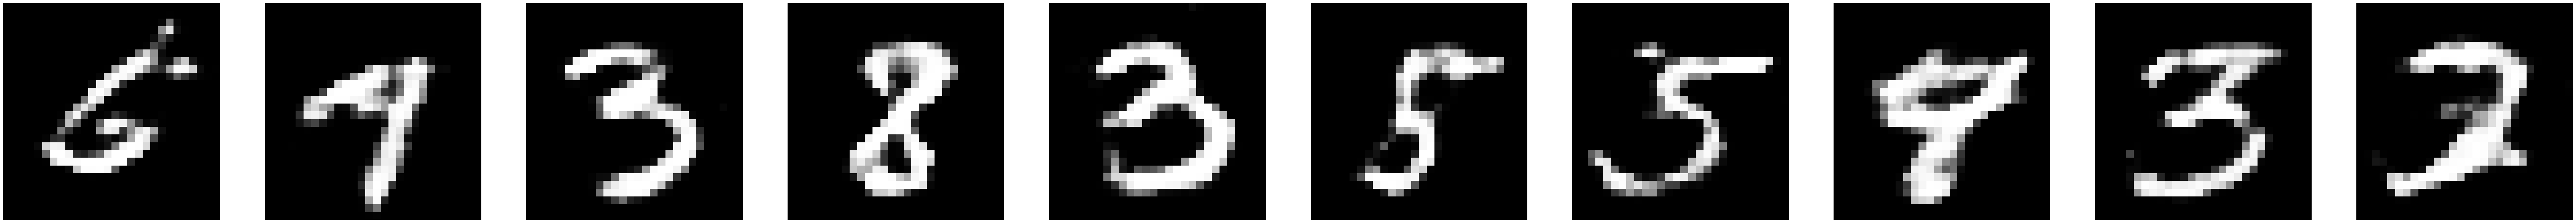

Epoch 36/50


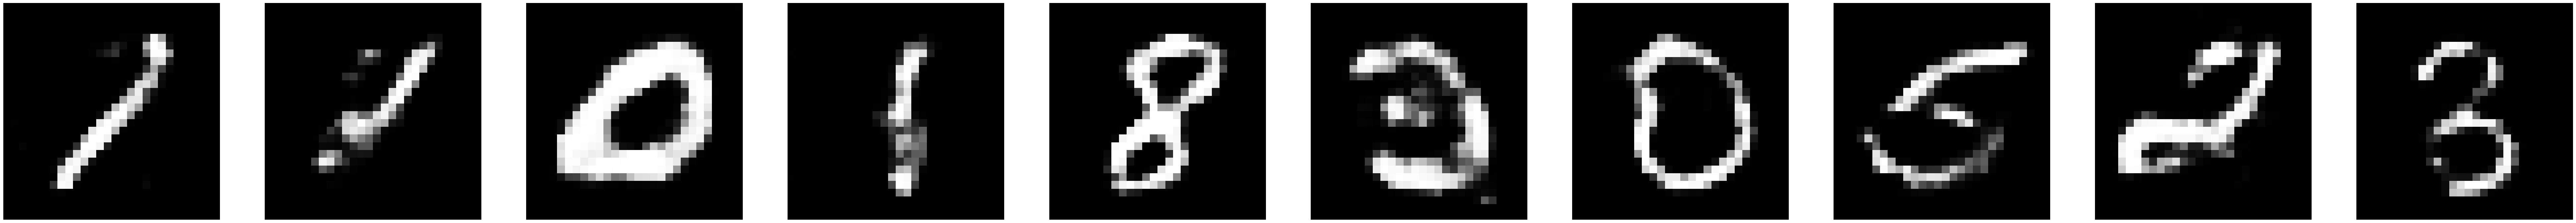

Epoch 37/50


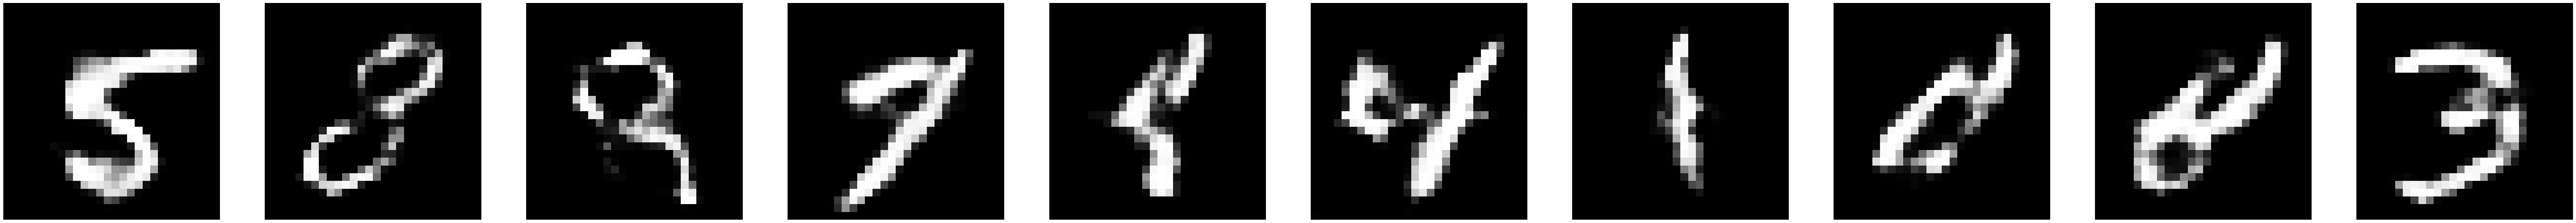

Epoch 38/50


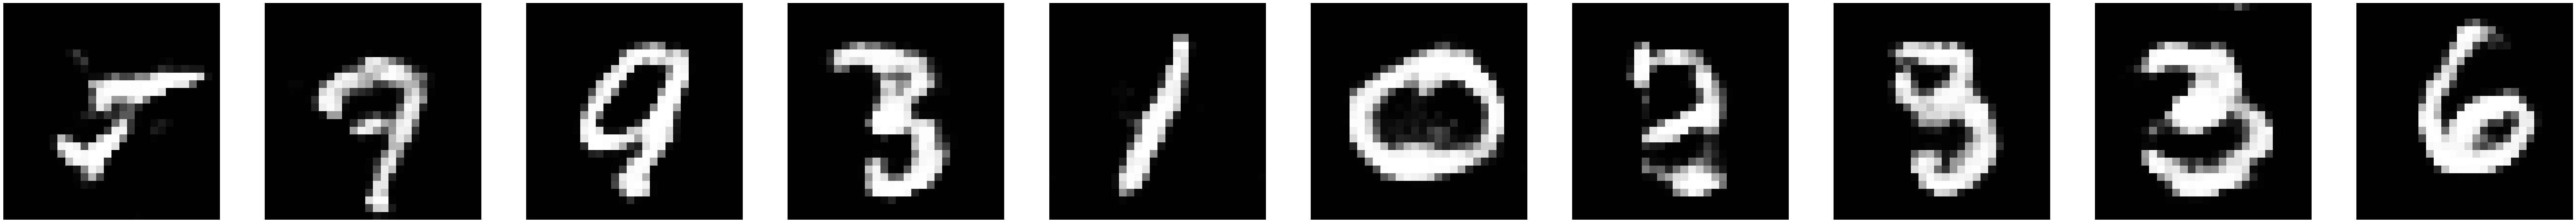

Epoch 39/50


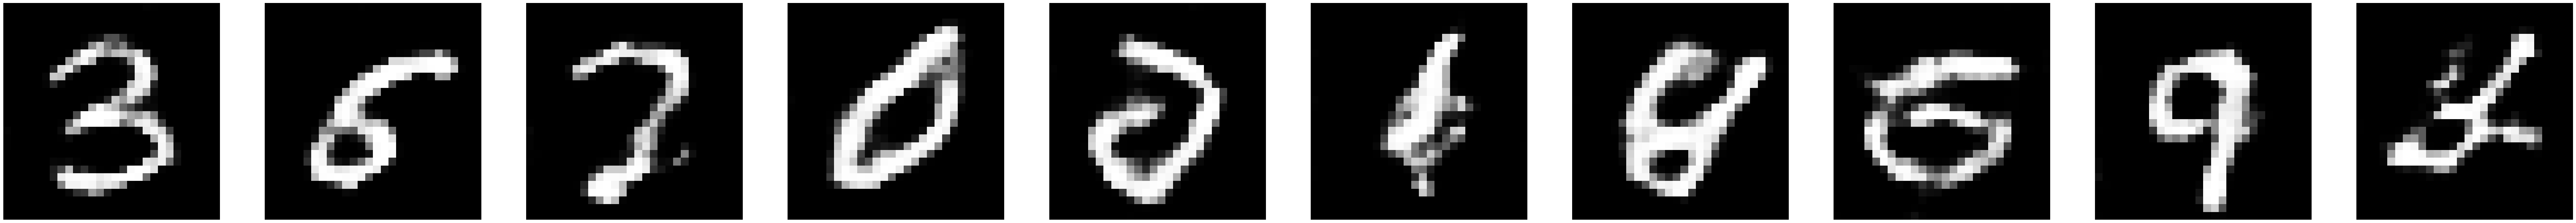

Epoch 40/50


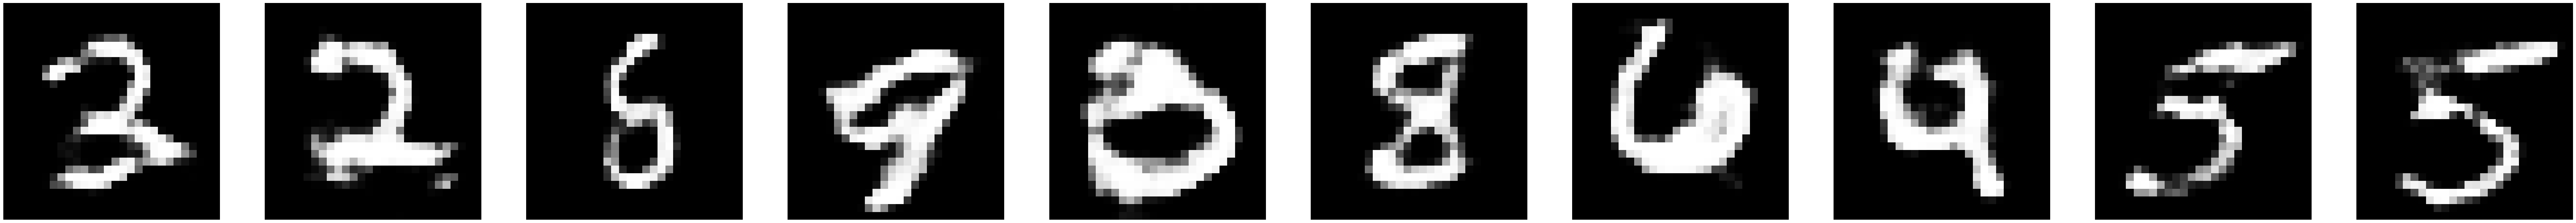

Epoch 41/50


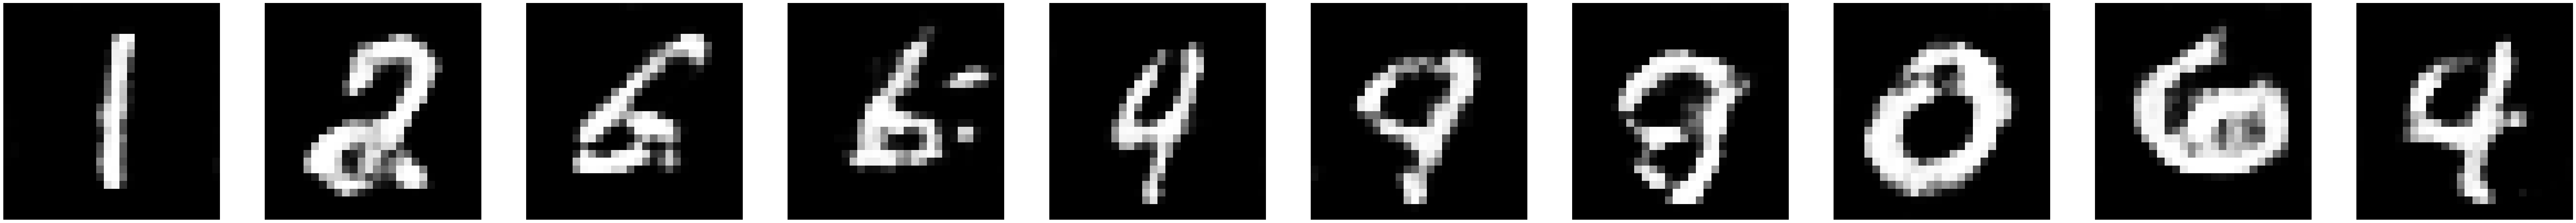

Epoch 42/50


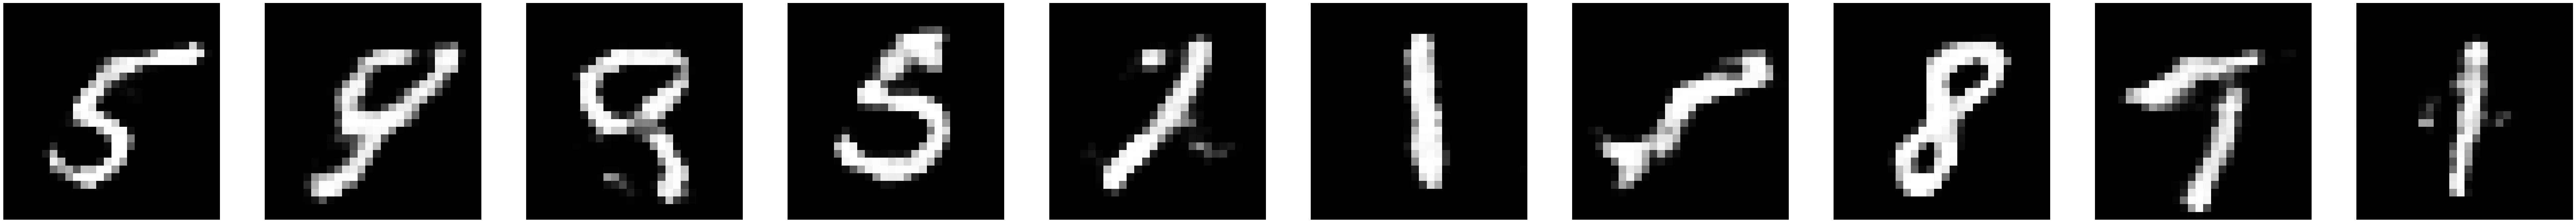

Epoch 43/50


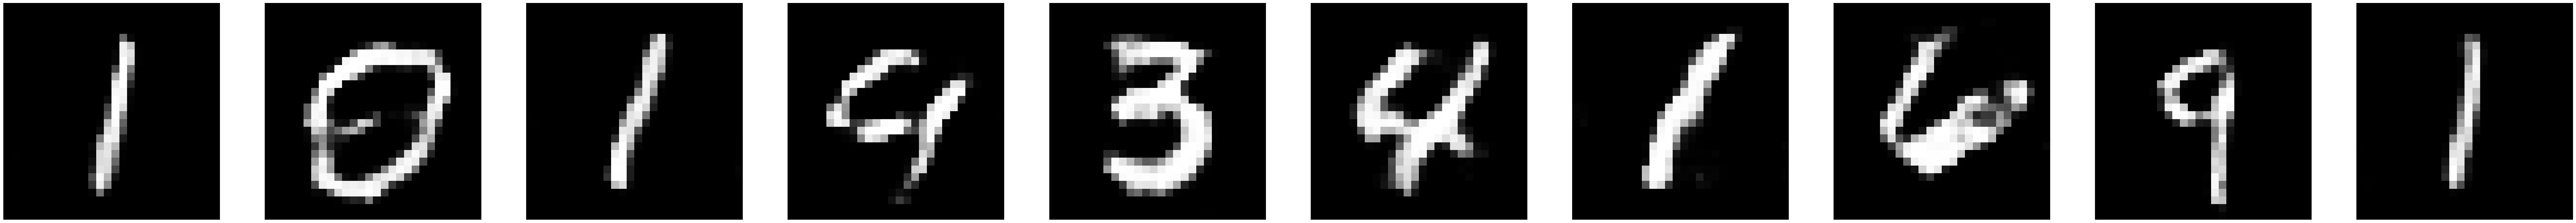

Epoch 44/50


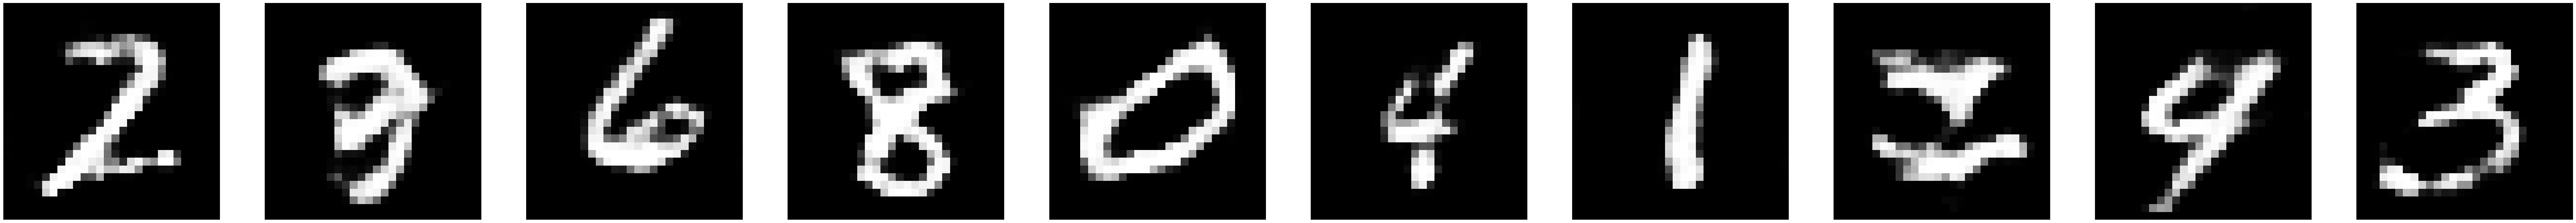

Epoch 45/50


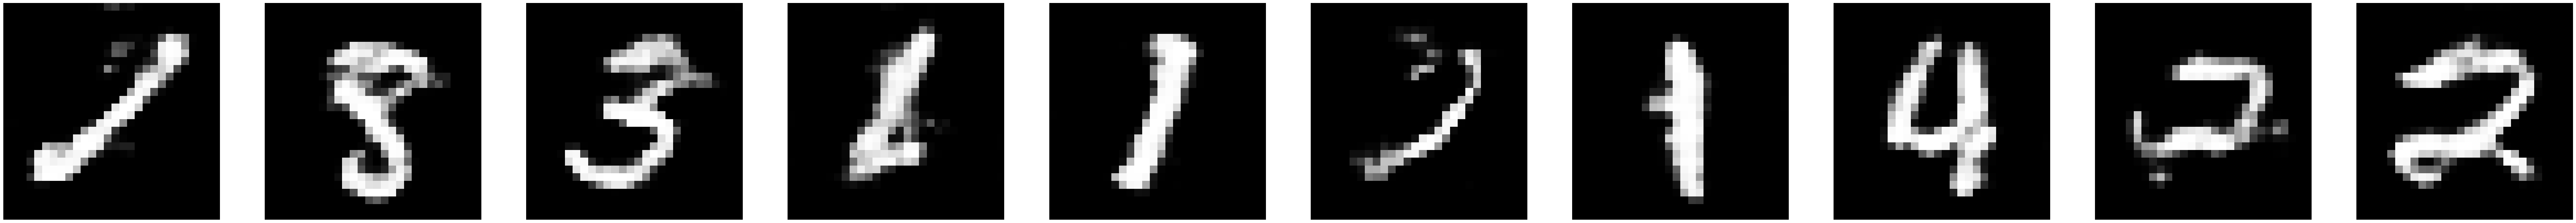

Epoch 46/50


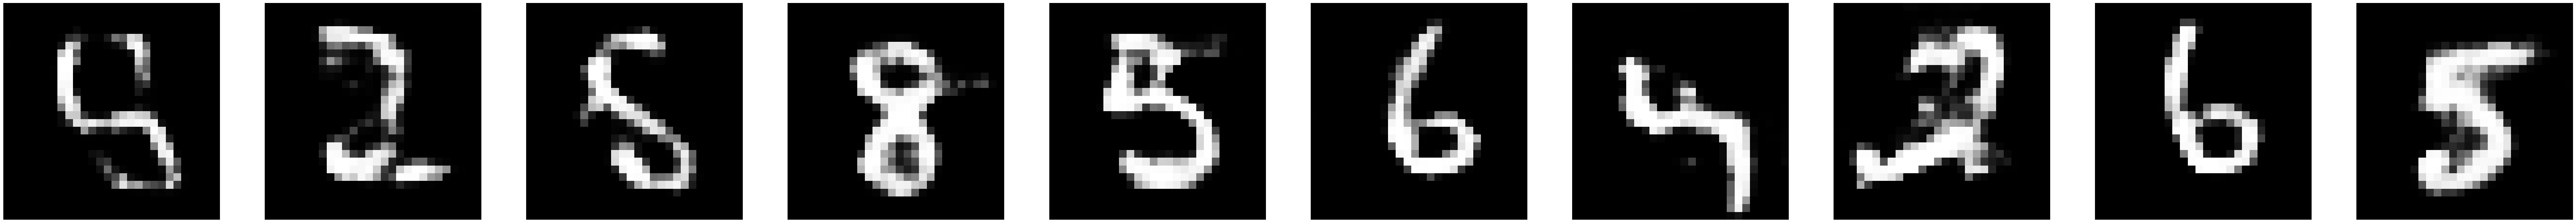

Epoch 47/50


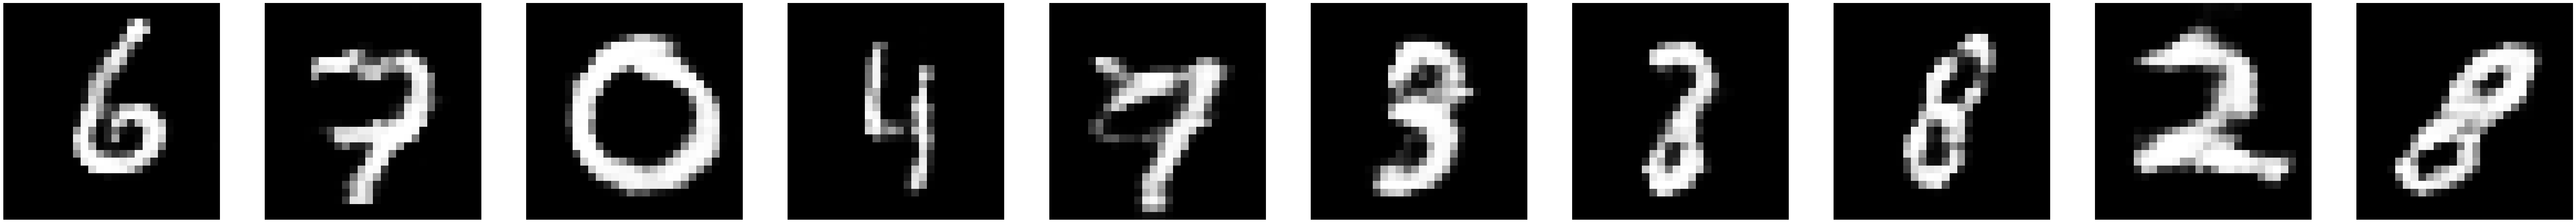

Epoch 48/50


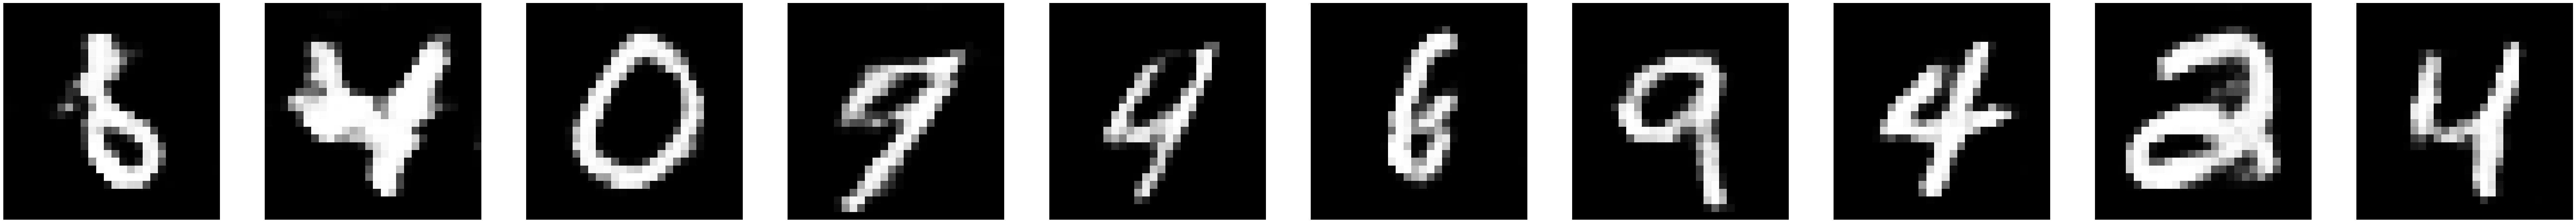

Epoch 49/50


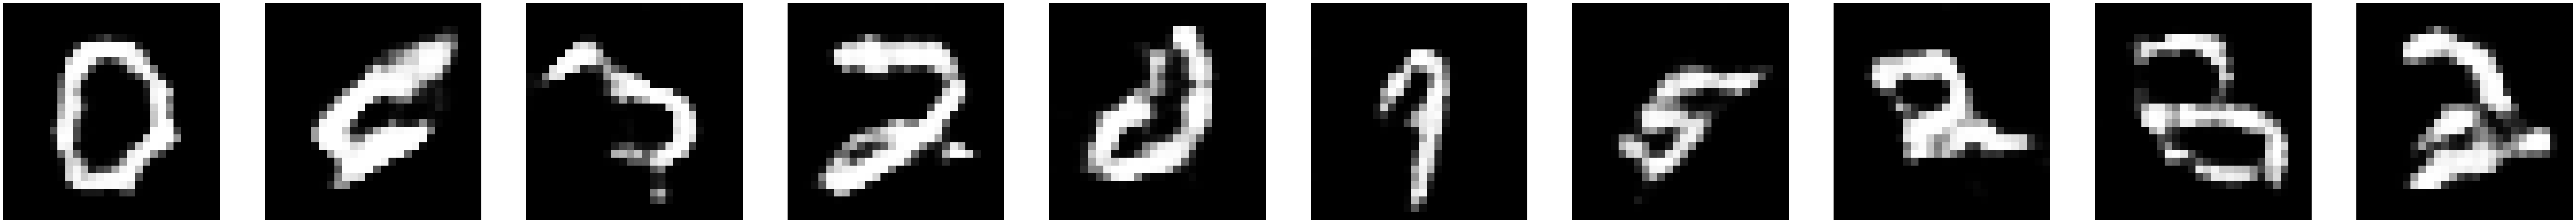

In [ ]:

input_distribution_size = 100
learning_rate = 1e-4
batch_size = 256
num_epochs = 50

generator = Generator()
discriminator = Discriminator()
noise = NoiseGenerator(input_distribution_size)
d_optim = tf.optimizers.Adam(learning_rate)
g_optim = tf.optimizers.Adam(learning_rate)

train_step = train_step_template(
    generator=generator,
    discriminator=discriminator,
    noise=noise,
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_f=min_max_discriminator_loss,
    g_loss_f=min_max_generator_loss,
)

gen_step = gen_step_template(
    generator=generator,
    noise=noise
)

train(
    train_step=train_step, 
    gen_step=gen_step,
    batch_size=batch_size,
    epochs=num_epochs
)

In [ ]:
def w_discriminator_loss(real_out, gen_out):
  return tf.reduce_mean(real_out - gen_out)

def w_generator_loss(gen_out):
  return tf.reduce_mean(gen_out)

Epoch 0/50


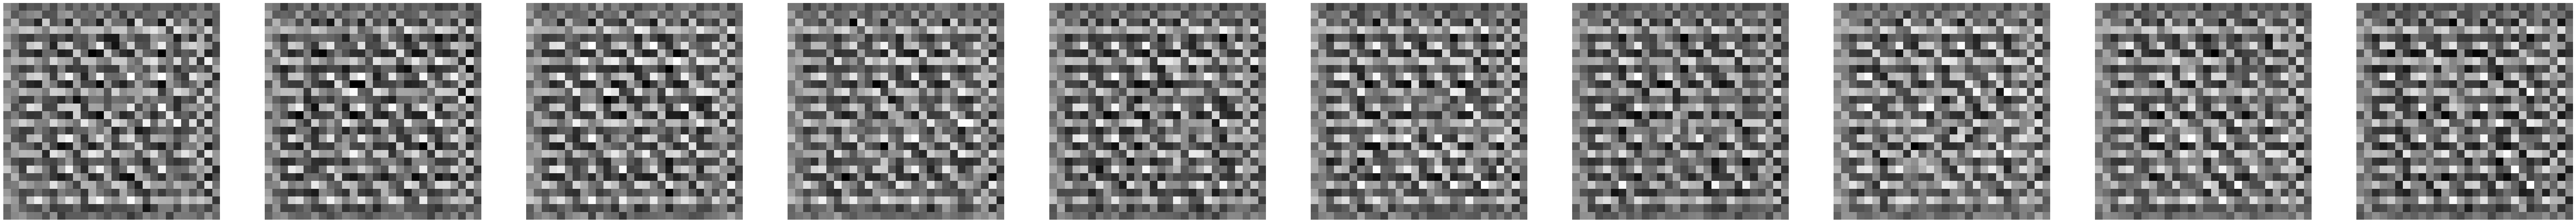

Epoch 1/50


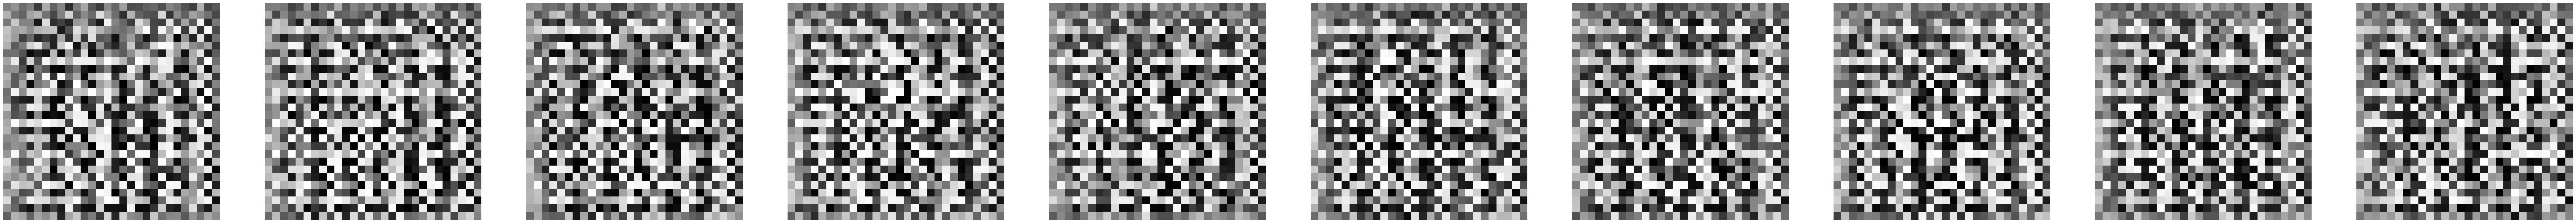

Epoch 2/50


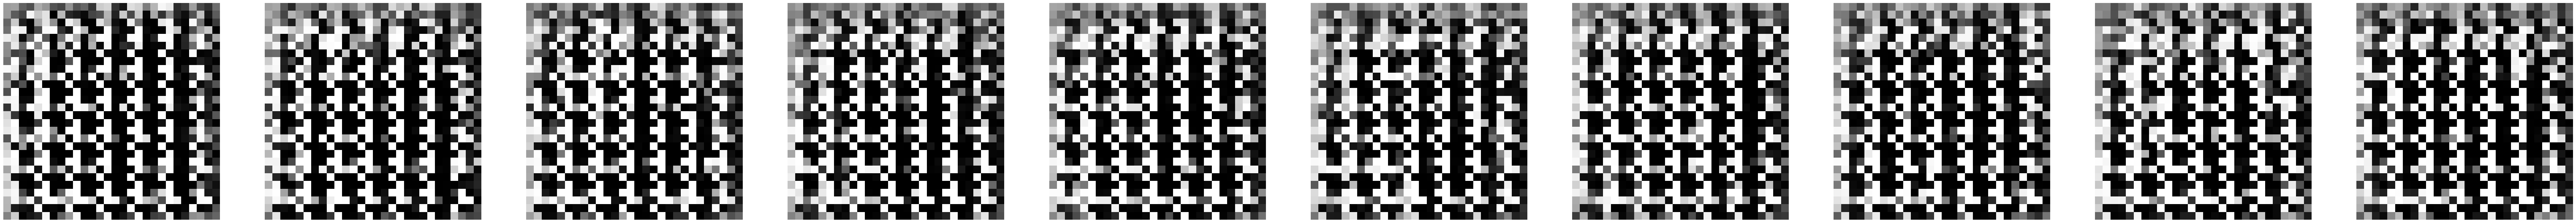

Epoch 3/50


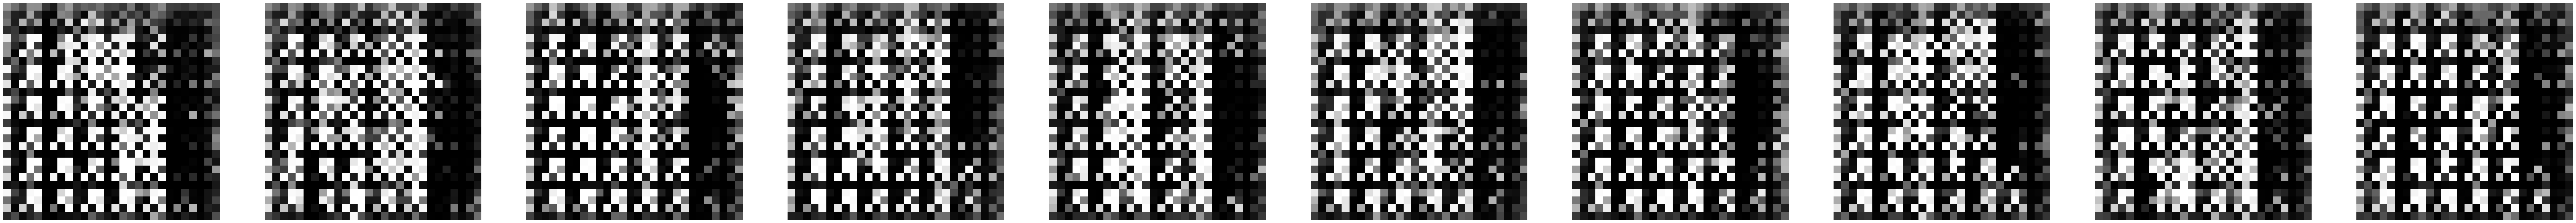

Epoch 4/50


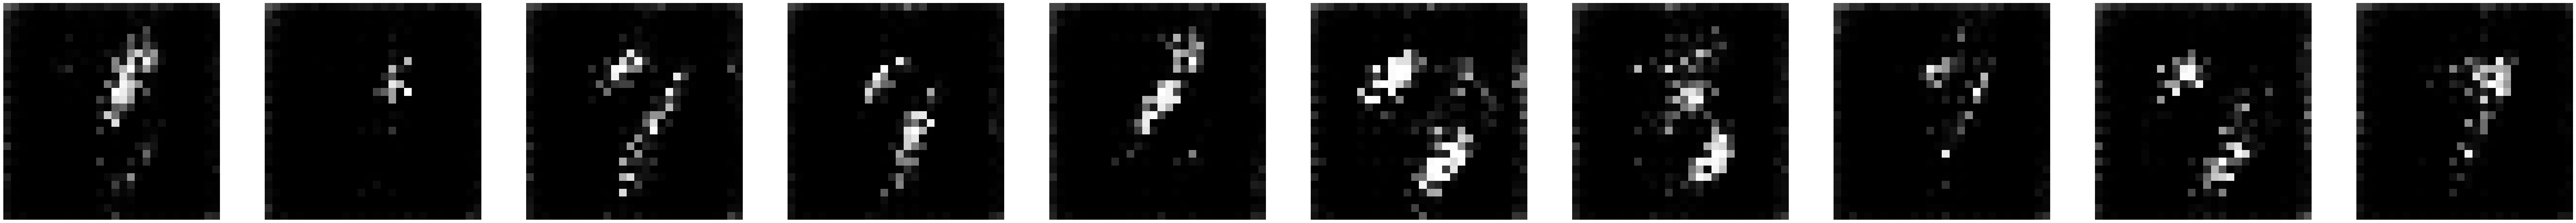

Epoch 5/50


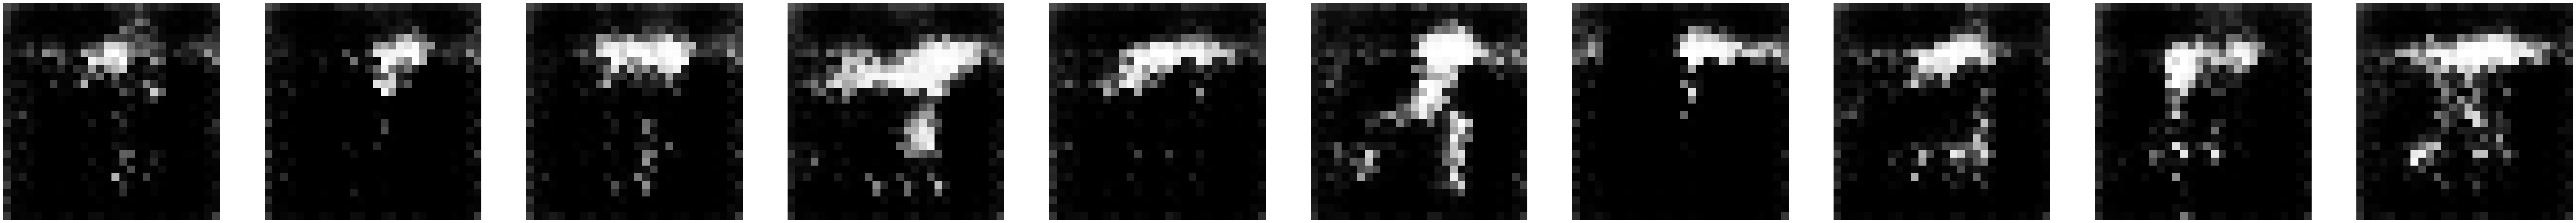

Epoch 6/50


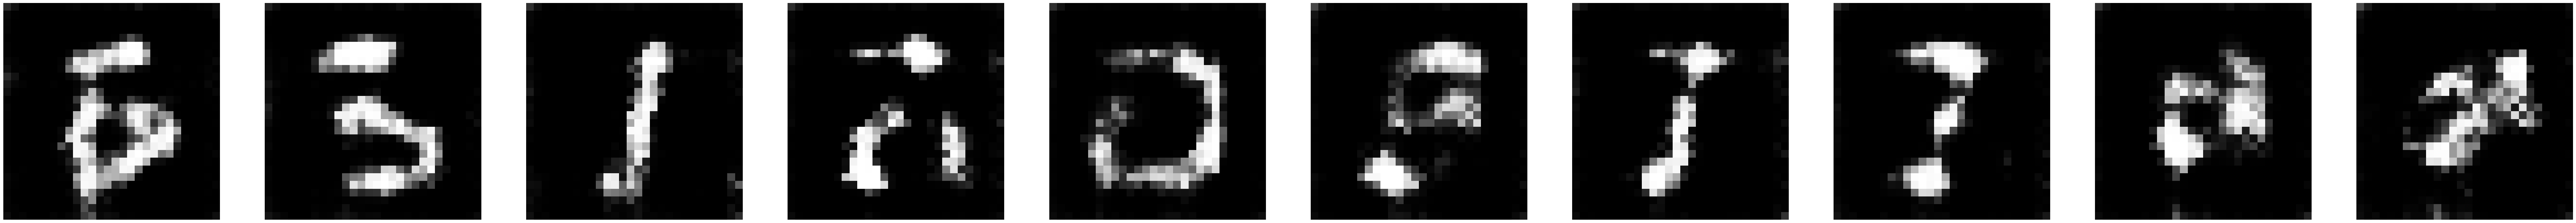

Epoch 7/50


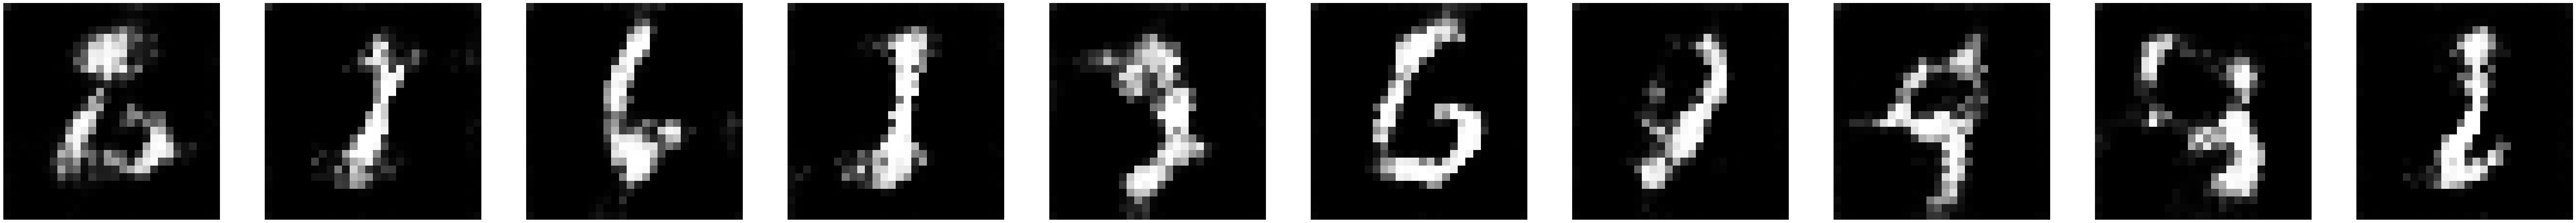

Epoch 8/50


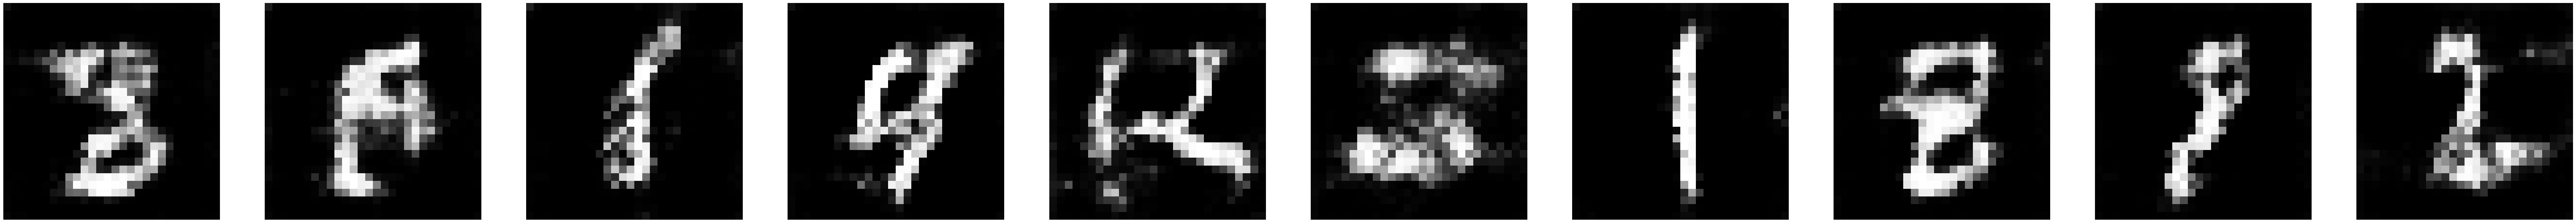

Epoch 9/50


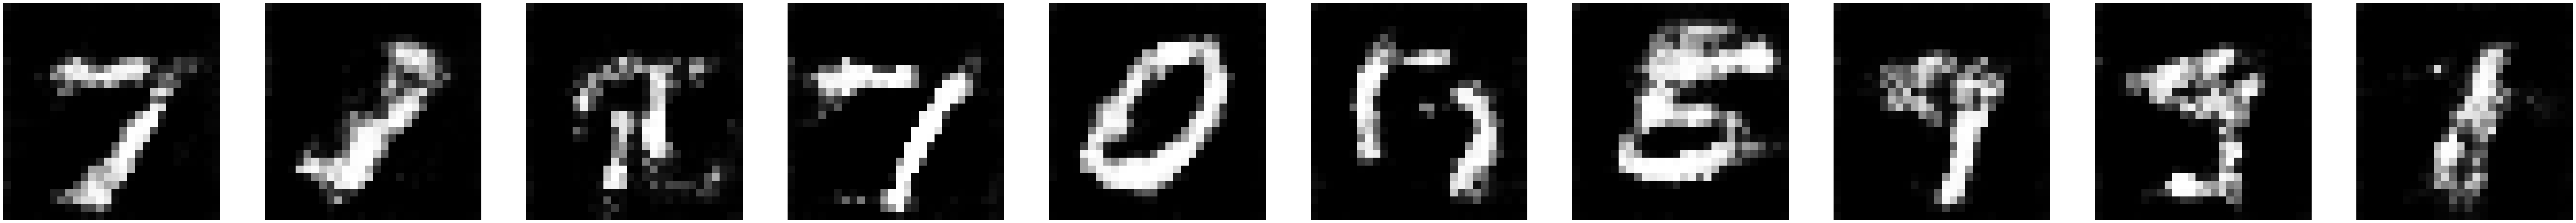

Epoch 10/50


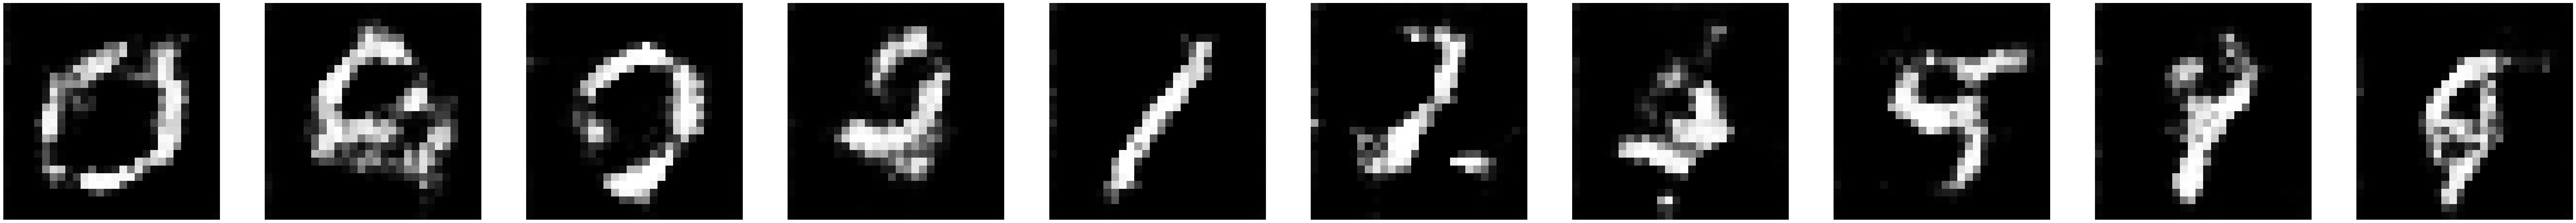

Epoch 11/50


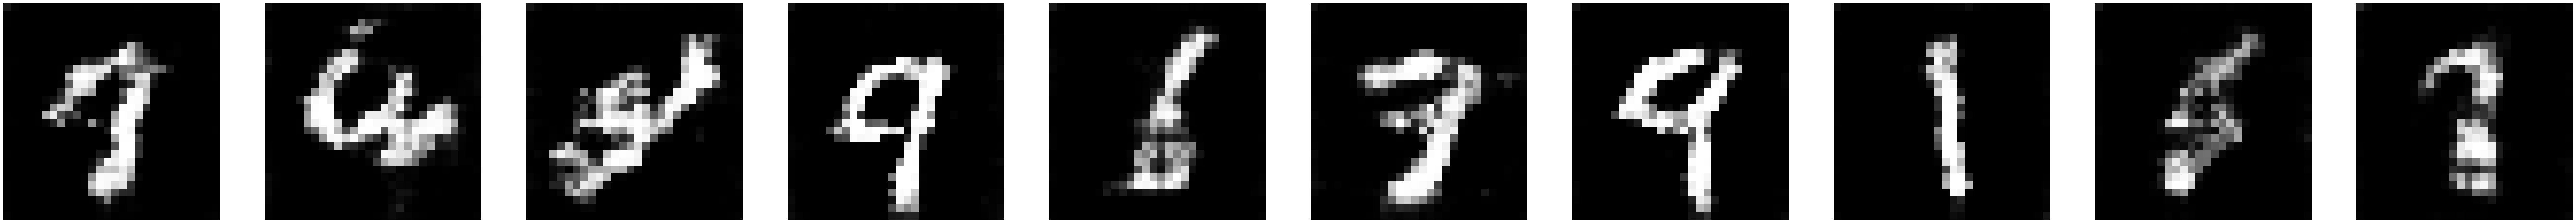

Epoch 12/50


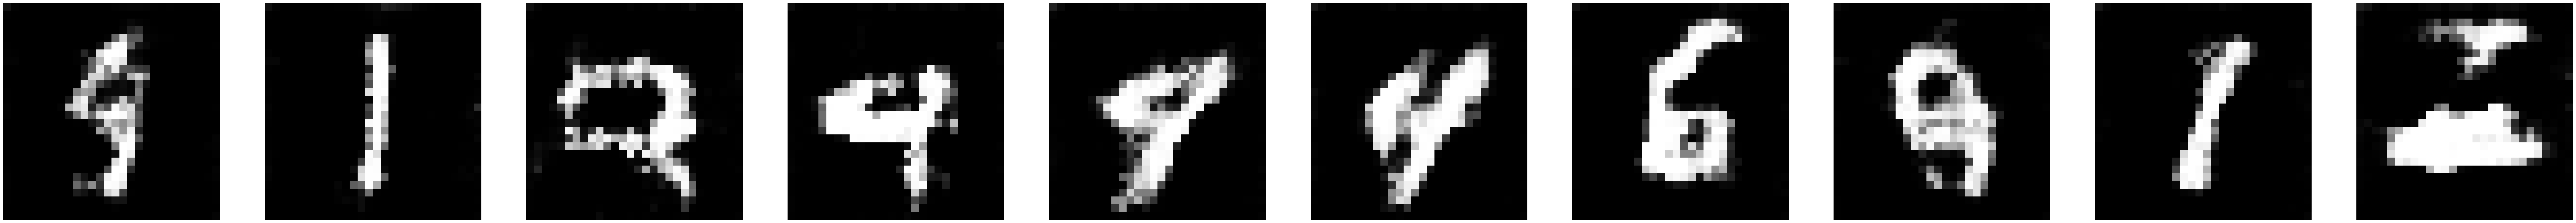

Epoch 13/50


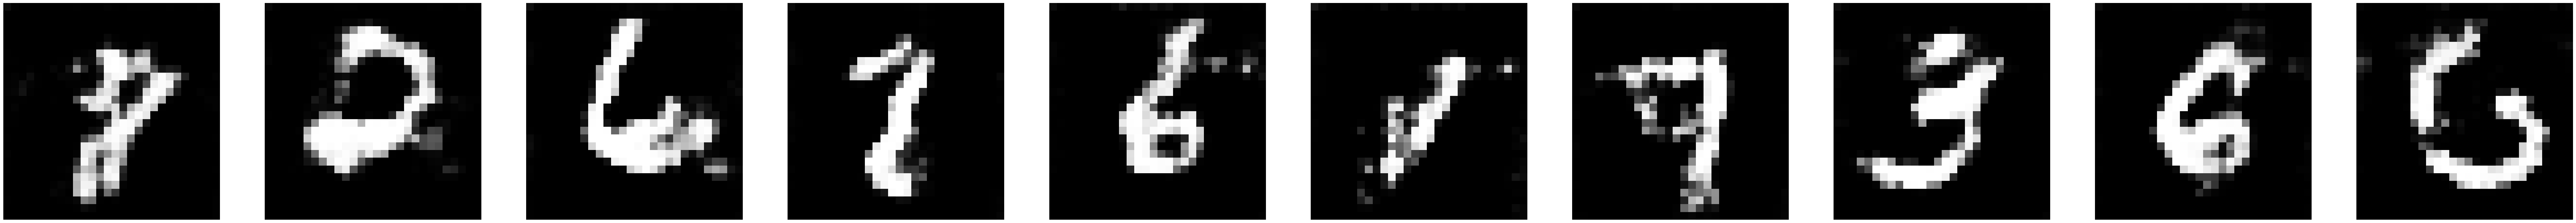

Epoch 14/50


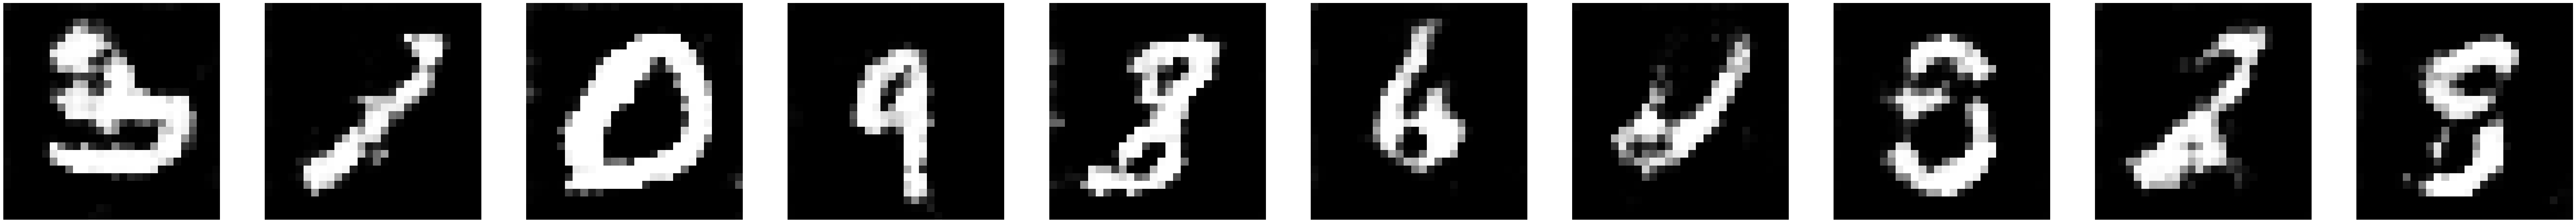

Epoch 15/50


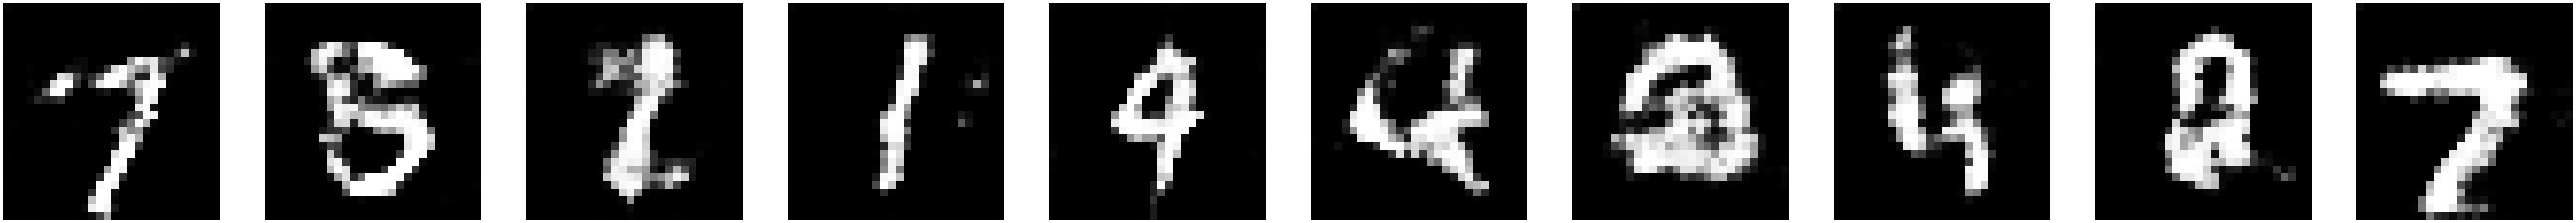

Epoch 16/50


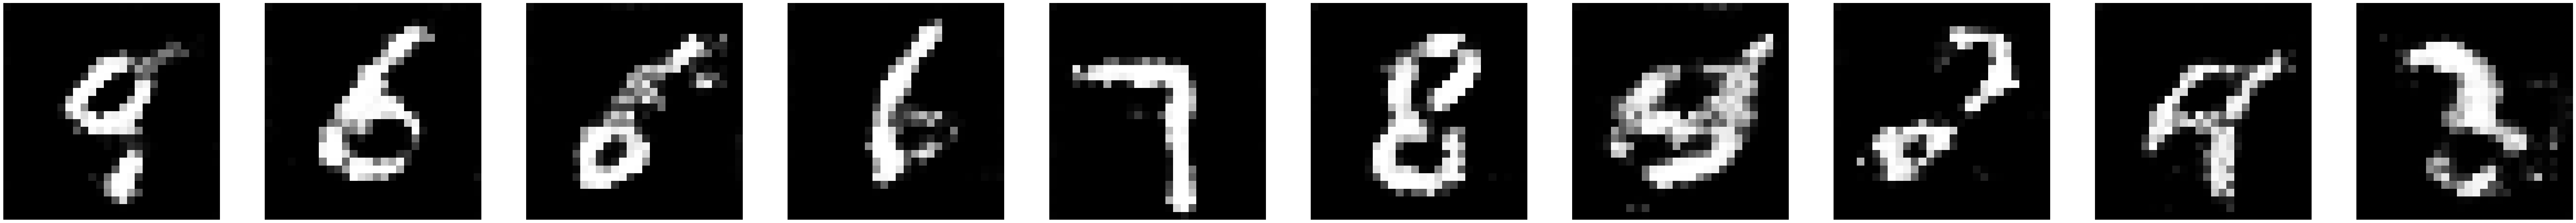

Epoch 17/50


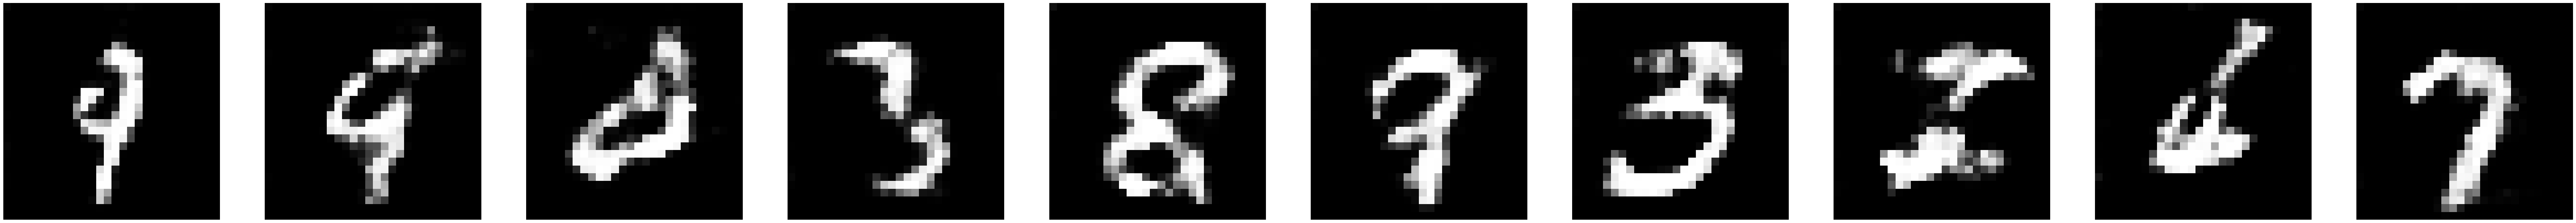

Epoch 18/50


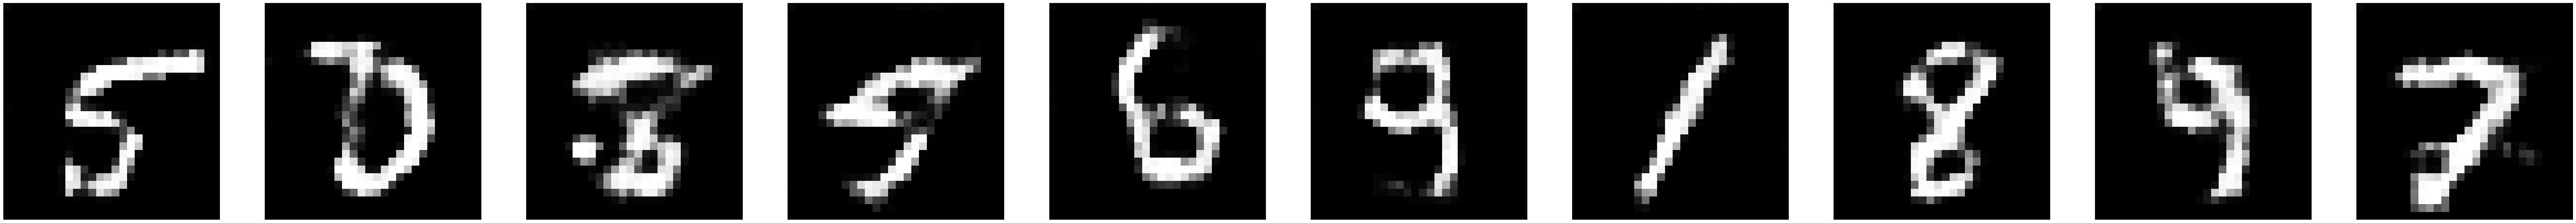

Epoch 19/50


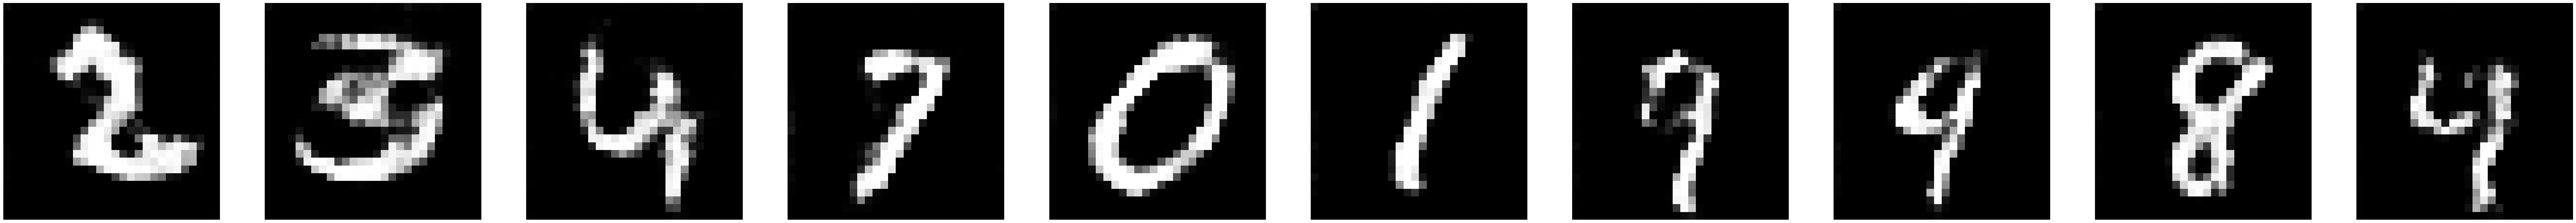

Epoch 20/50


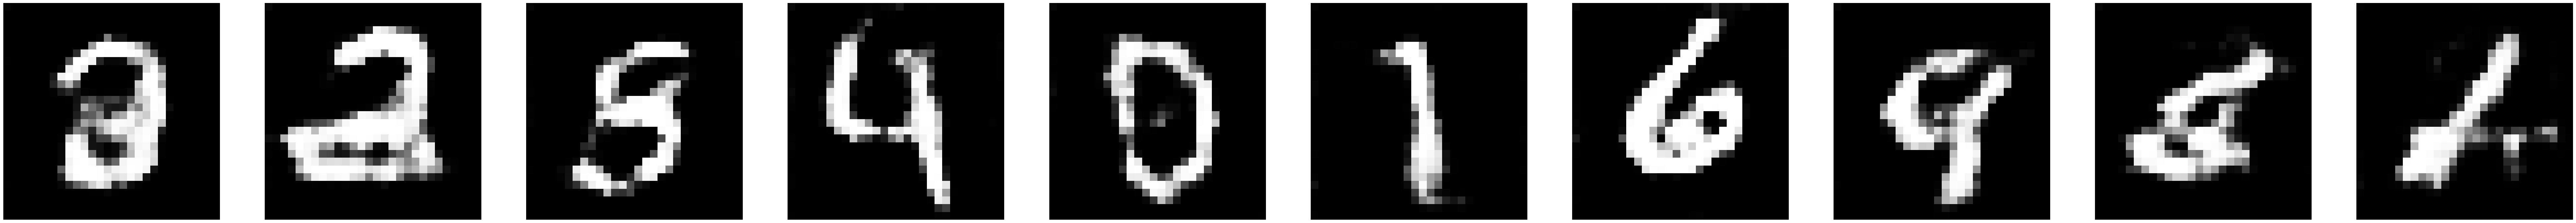

Epoch 21/50


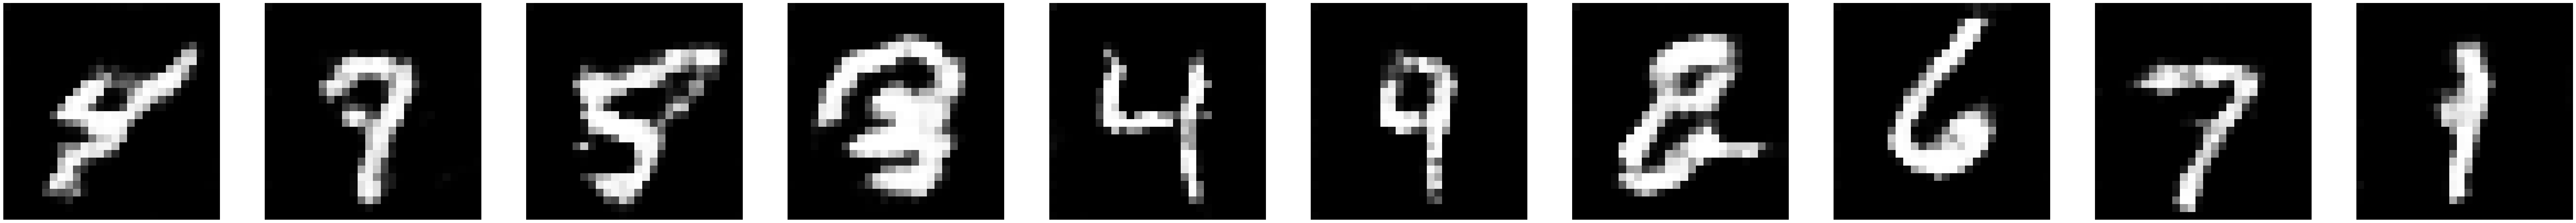

Epoch 22/50


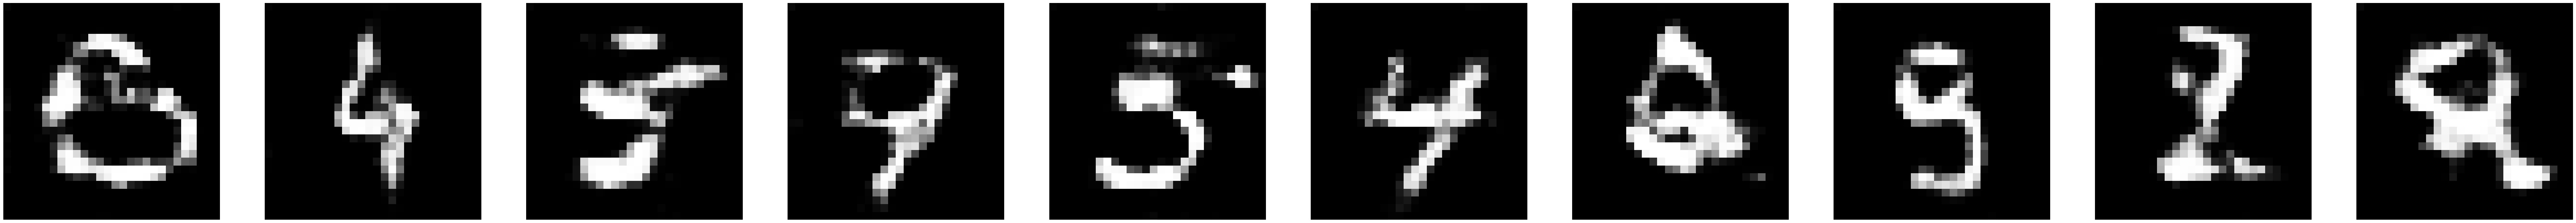

Epoch 23/50


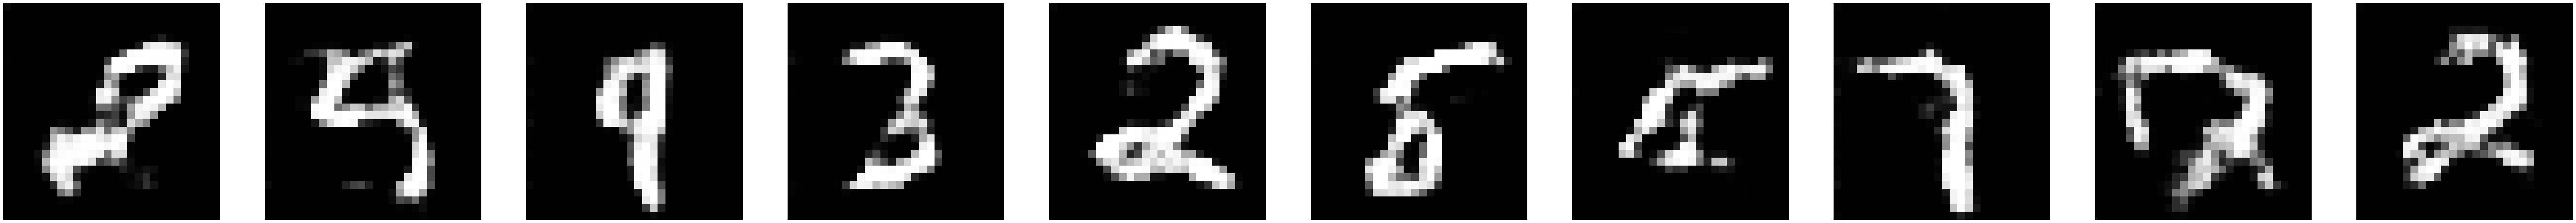

Epoch 24/50


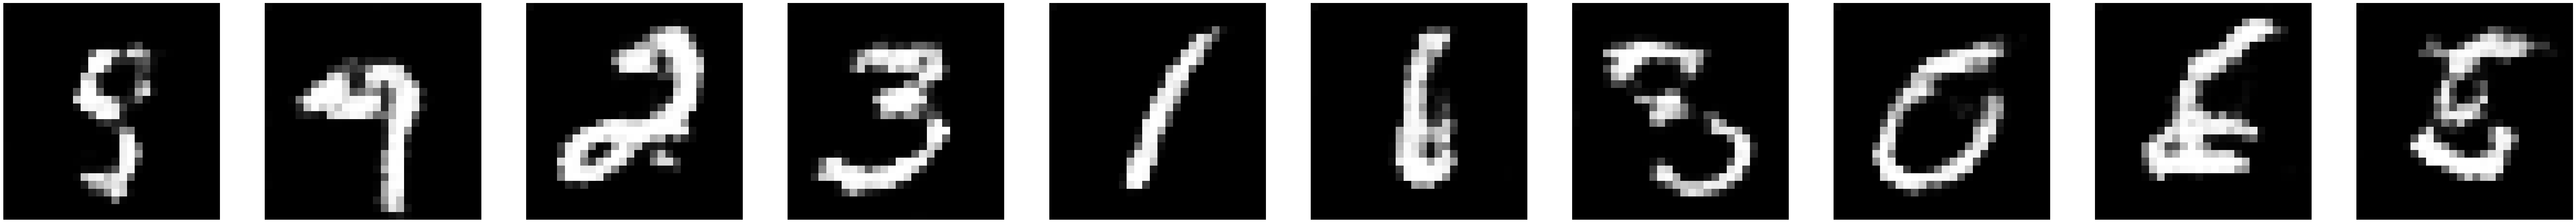

Epoch 25/50


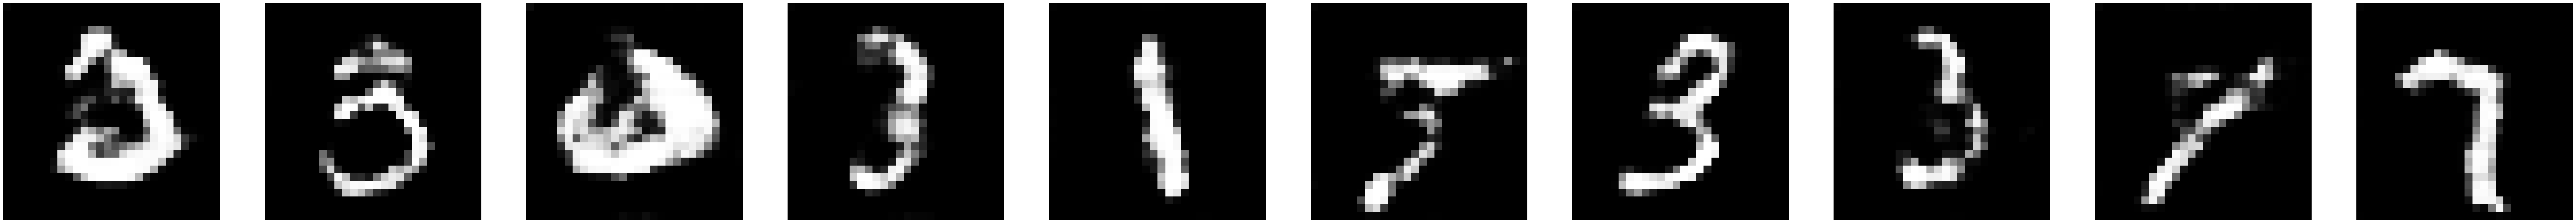

Epoch 26/50


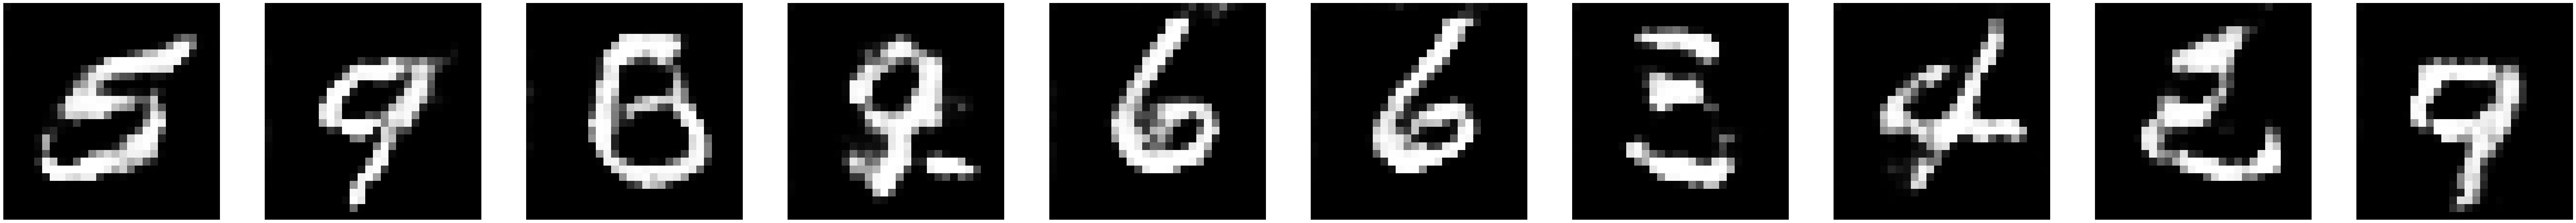

Epoch 27/50


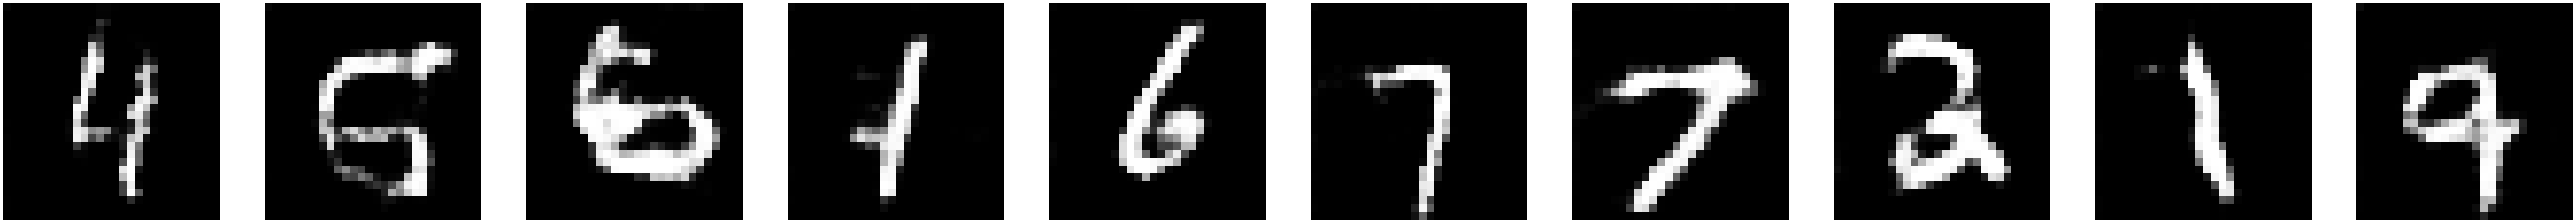

Epoch 28/50


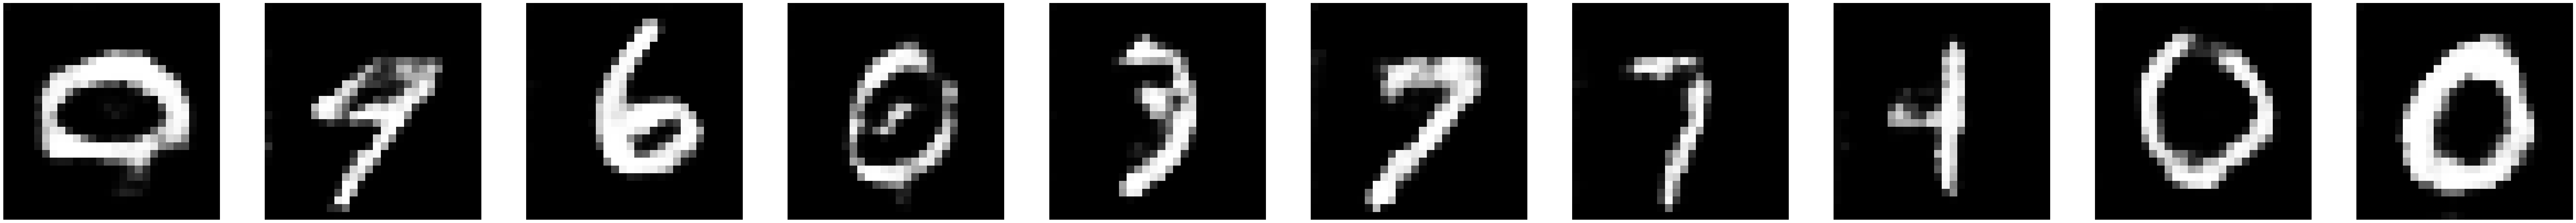

Epoch 29/50


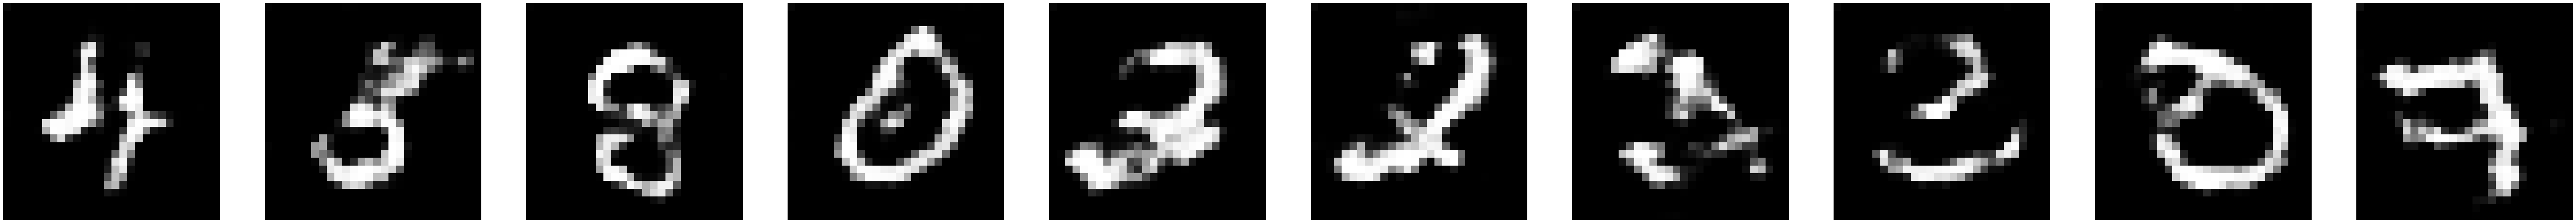

Epoch 30/50


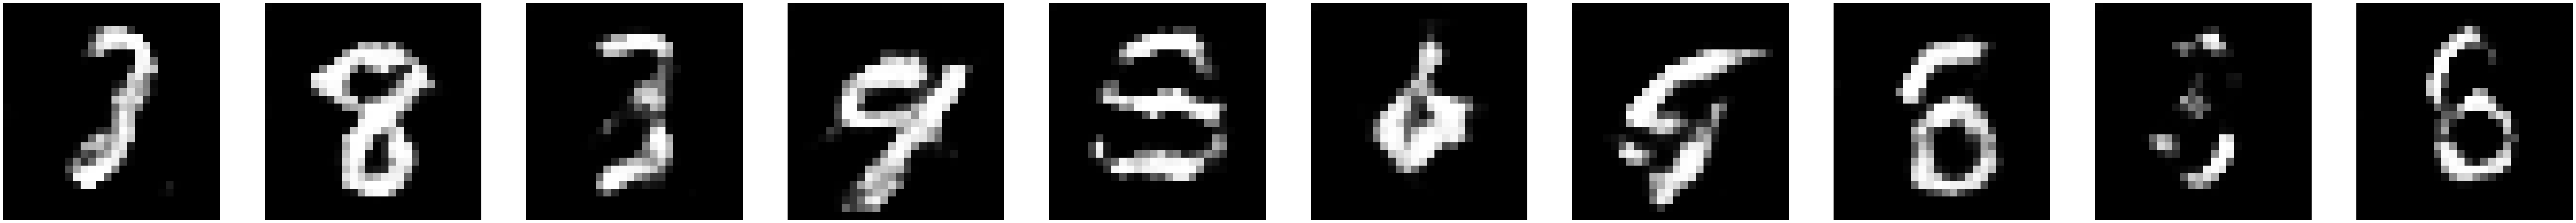

Epoch 31/50


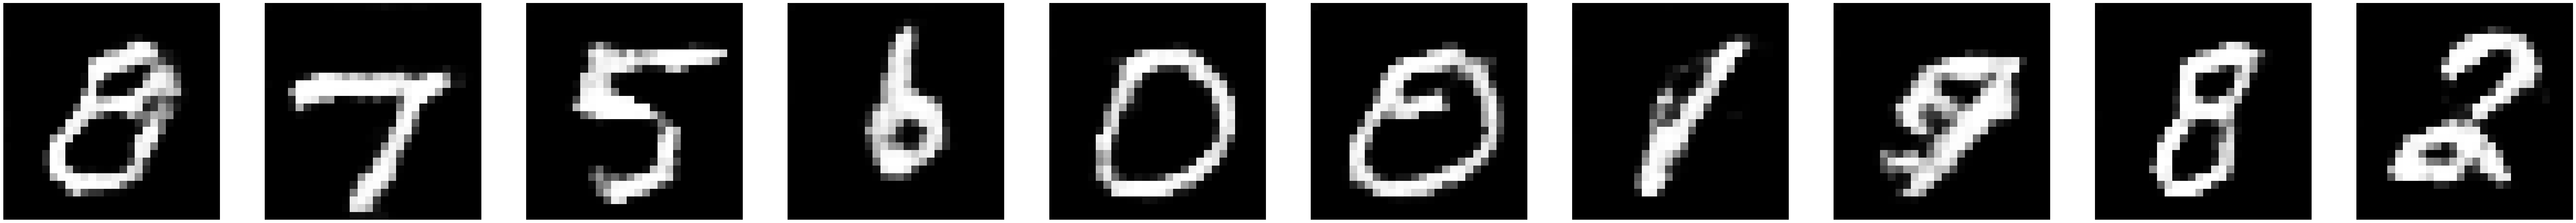

Epoch 32/50


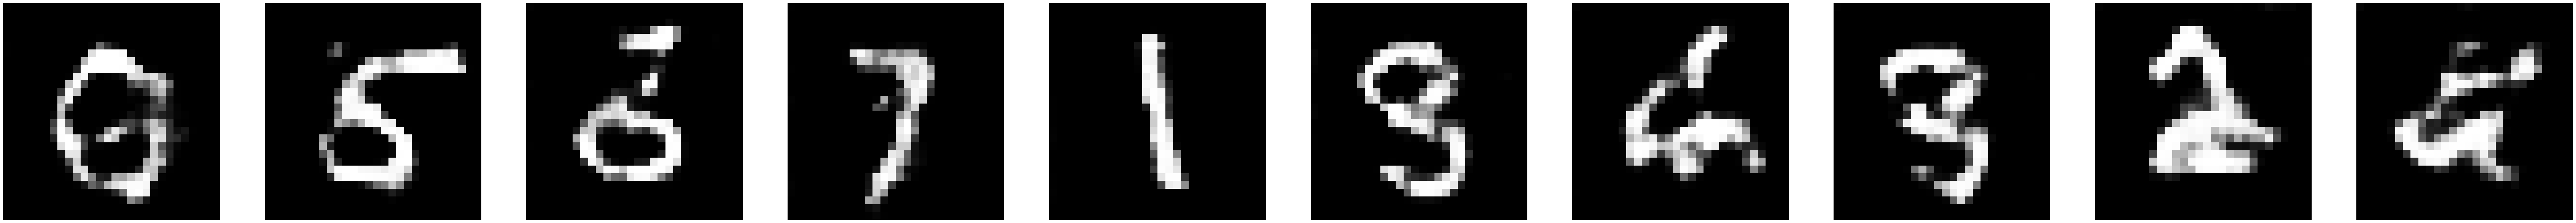

Epoch 33/50


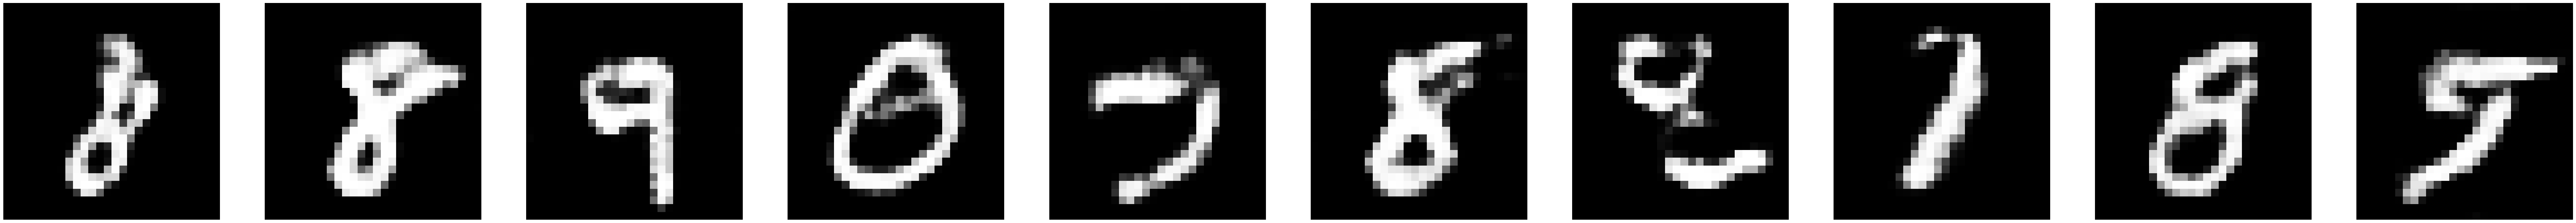

Epoch 34/50


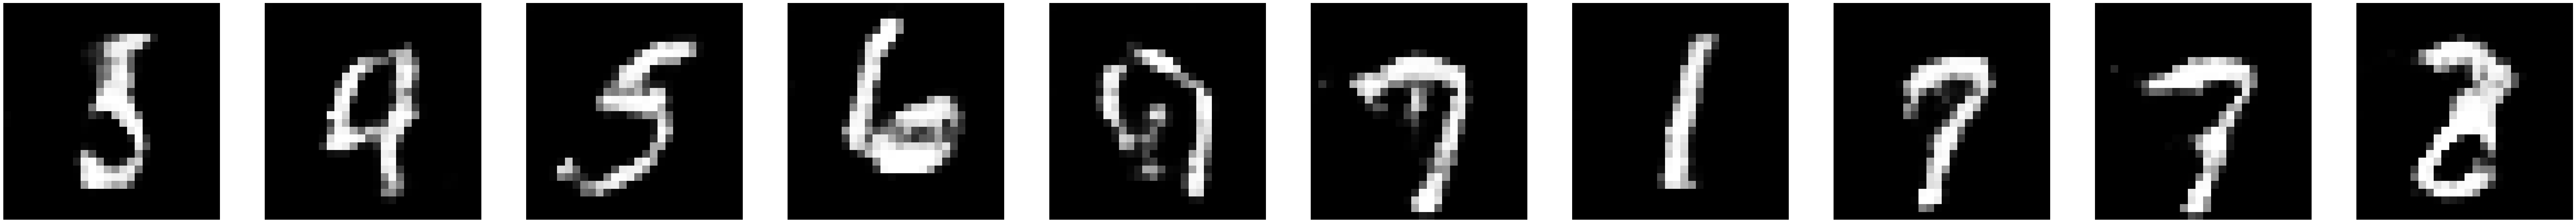

Epoch 35/50


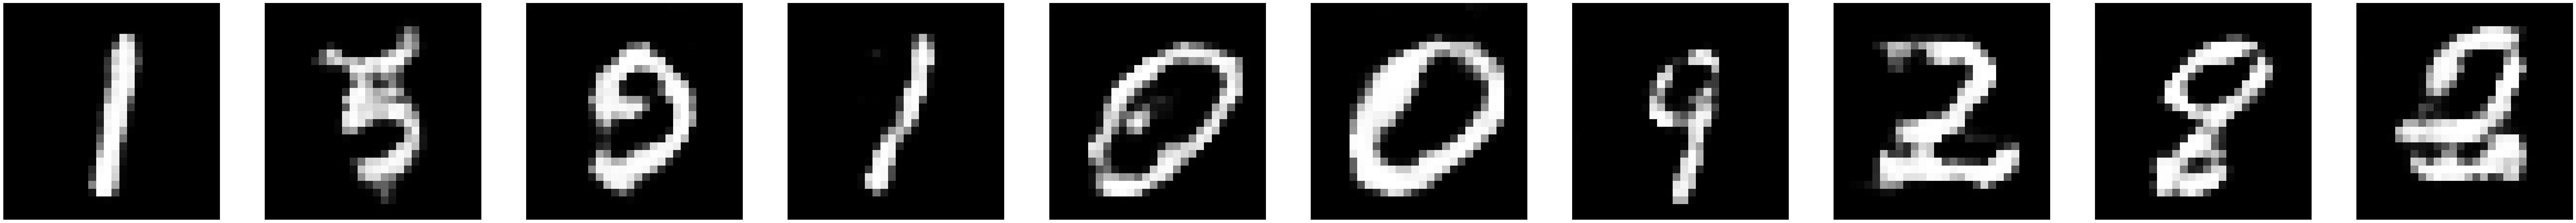

Epoch 36/50


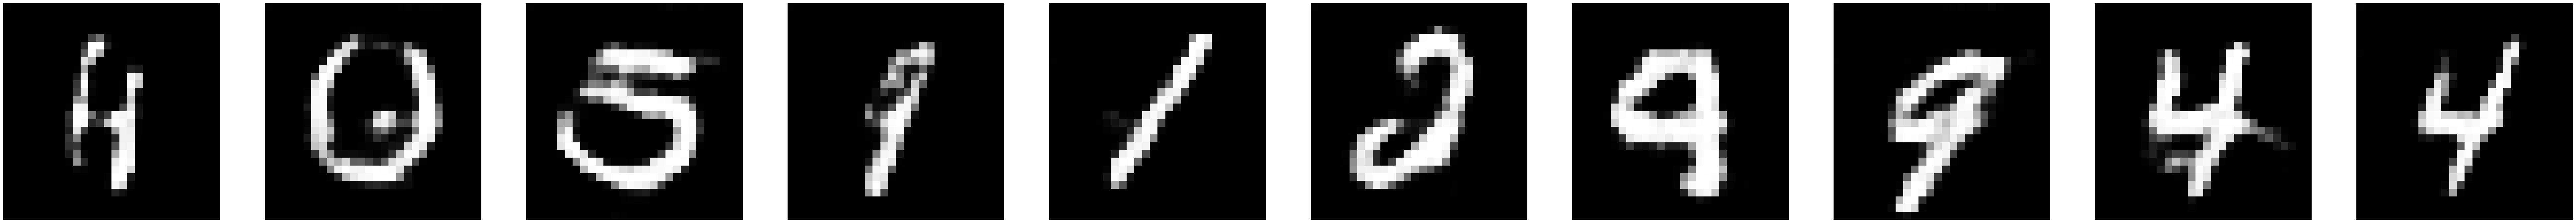

Epoch 37/50


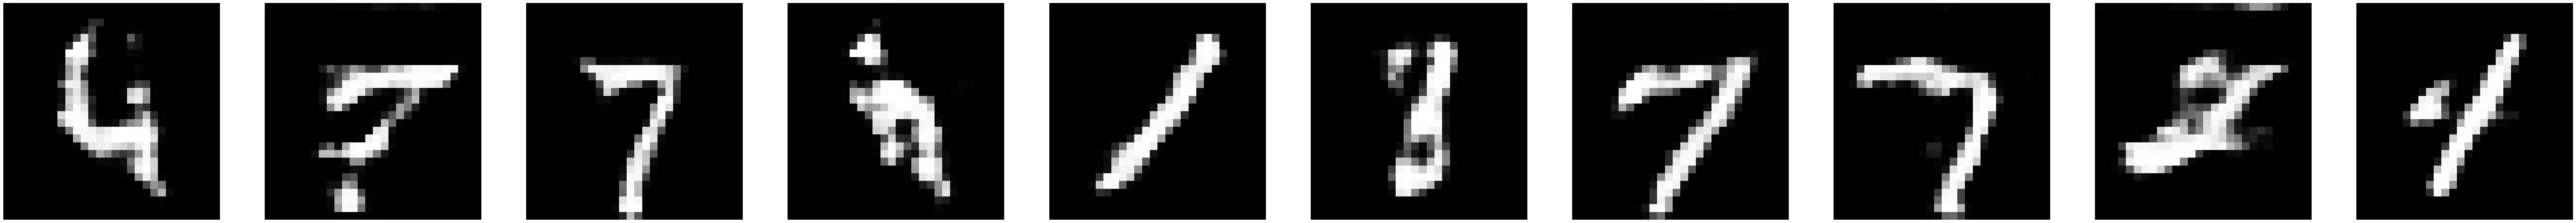

Epoch 38/50


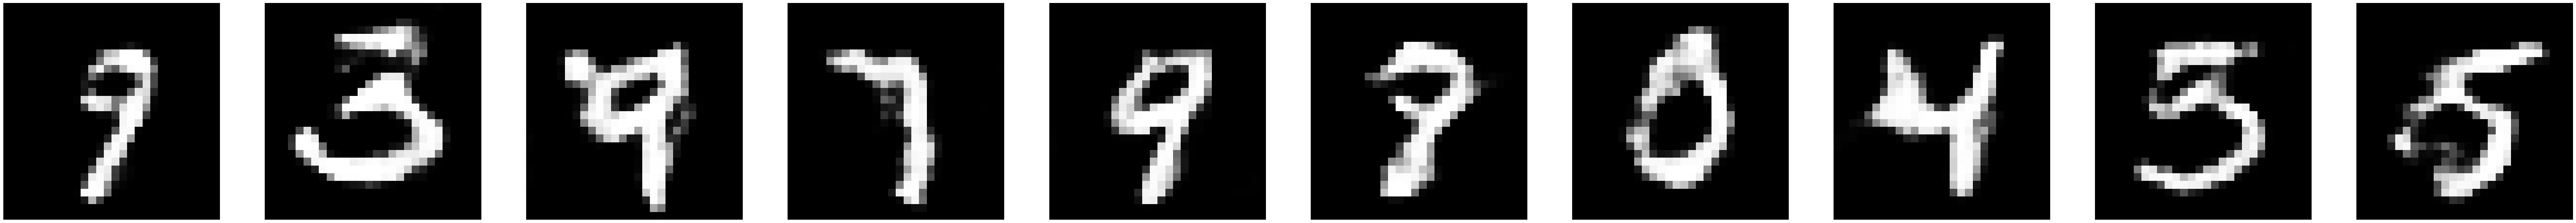

Epoch 39/50


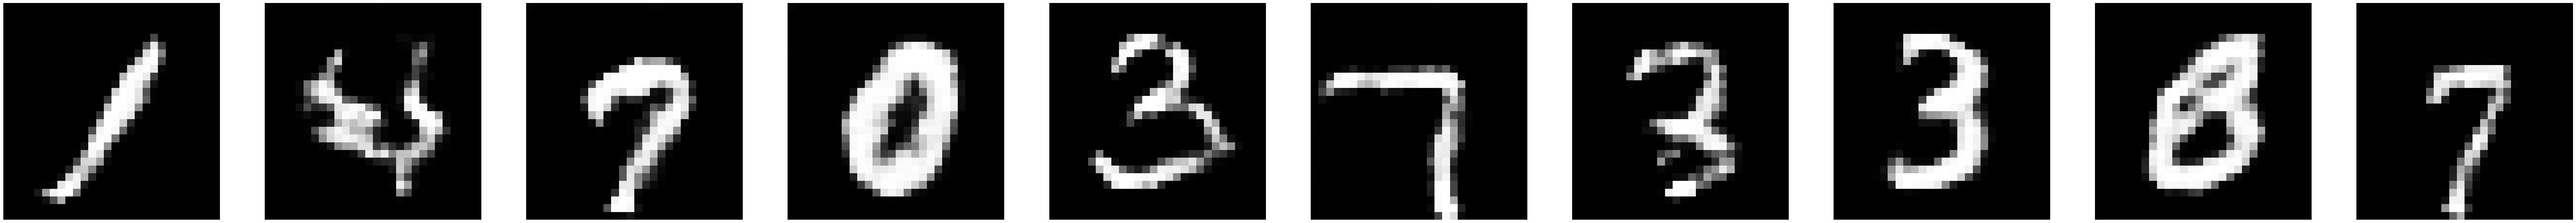

Epoch 40/50


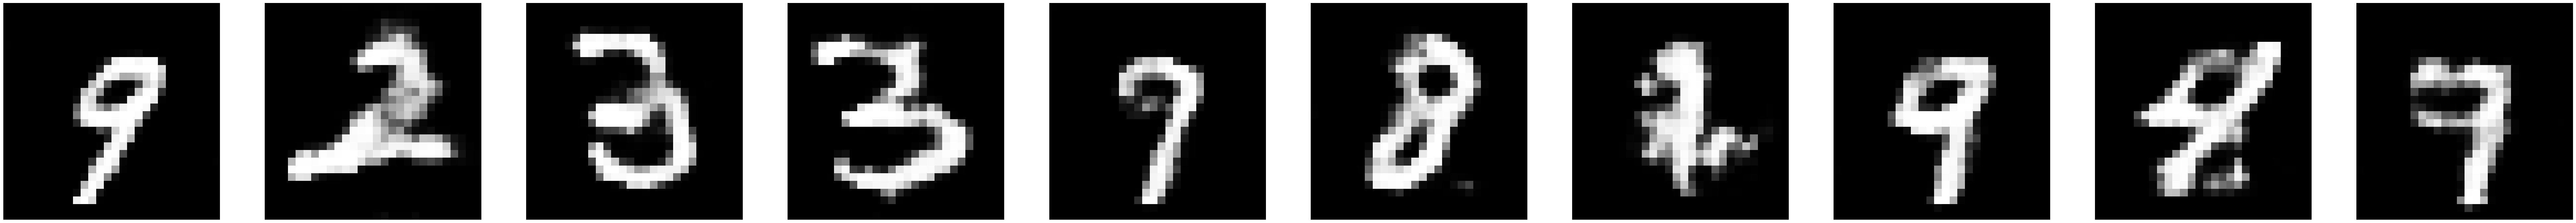

Epoch 41/50


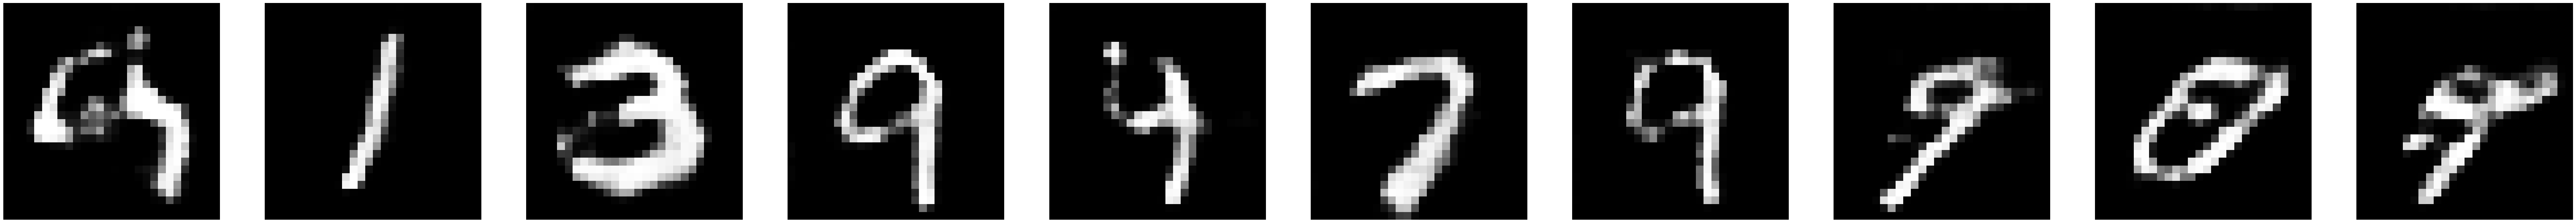

Epoch 42/50


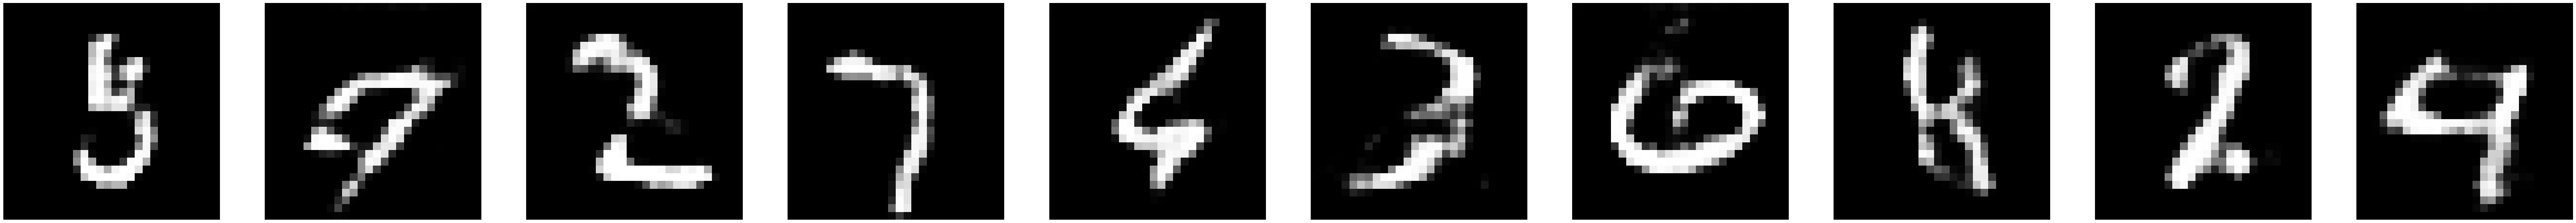

Epoch 43/50


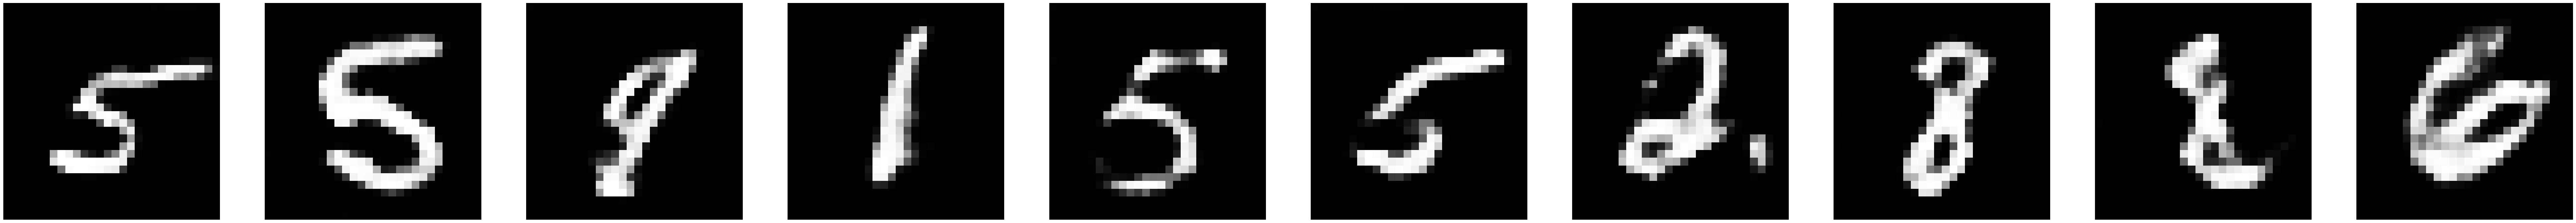

Epoch 44/50


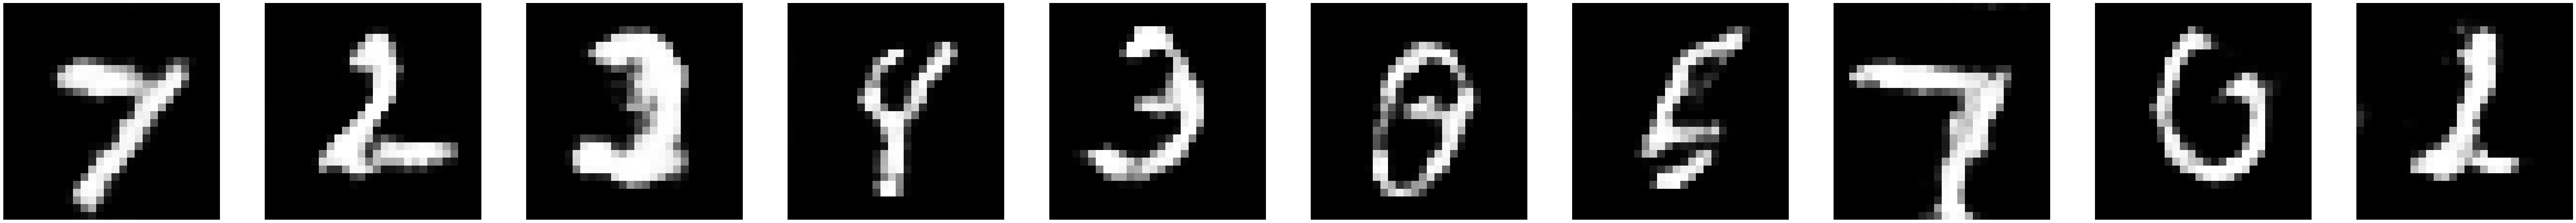

Epoch 45/50


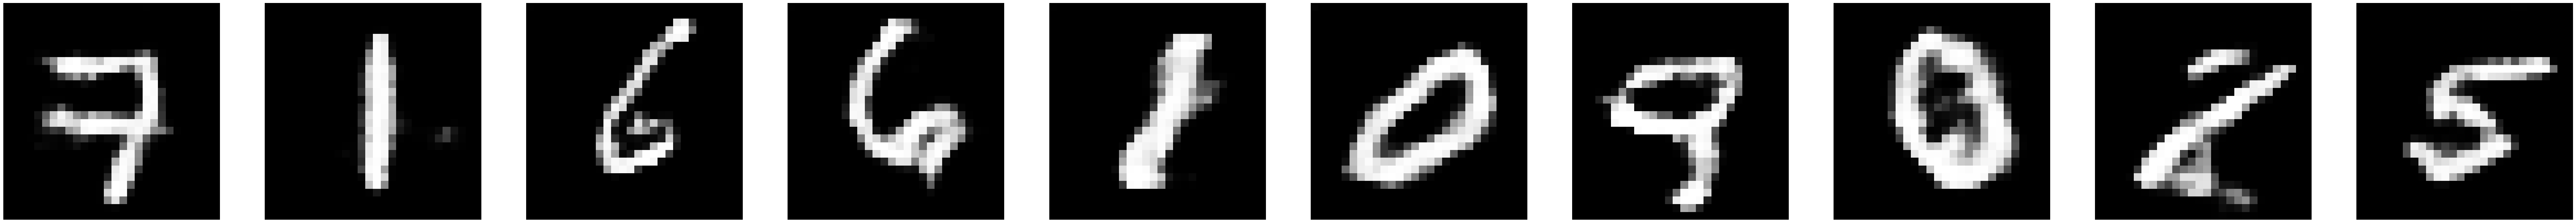

Epoch 46/50


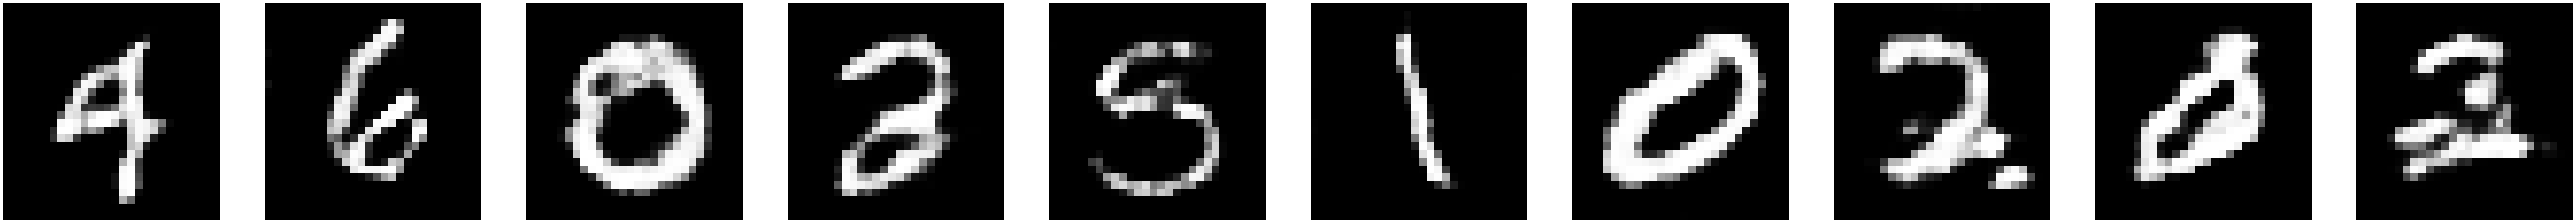

Epoch 47/50


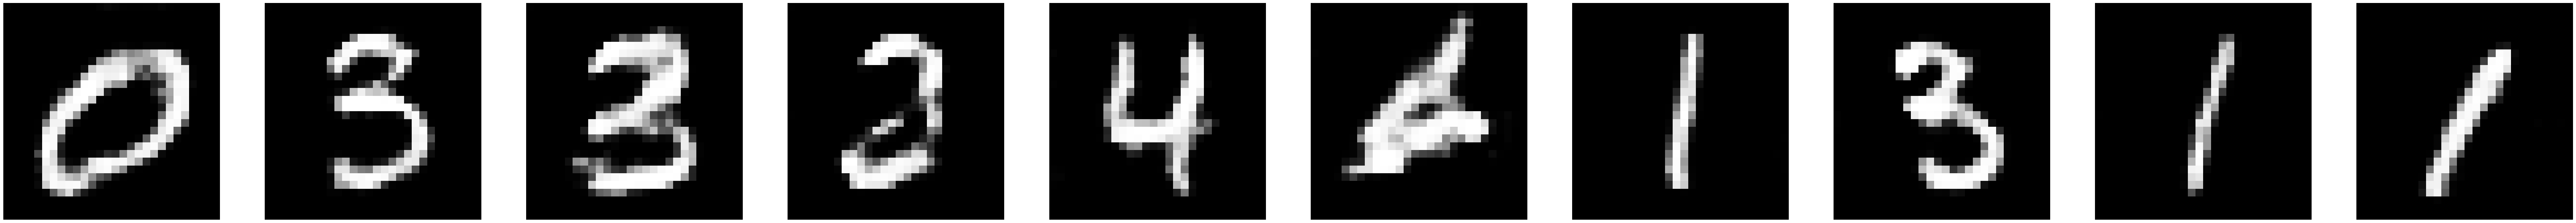

Epoch 48/50


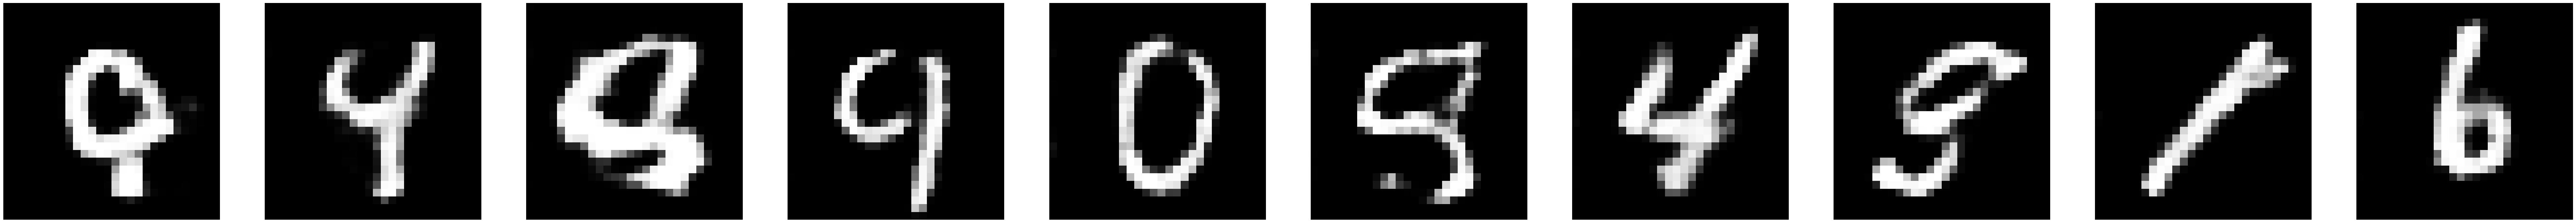

Epoch 49/50


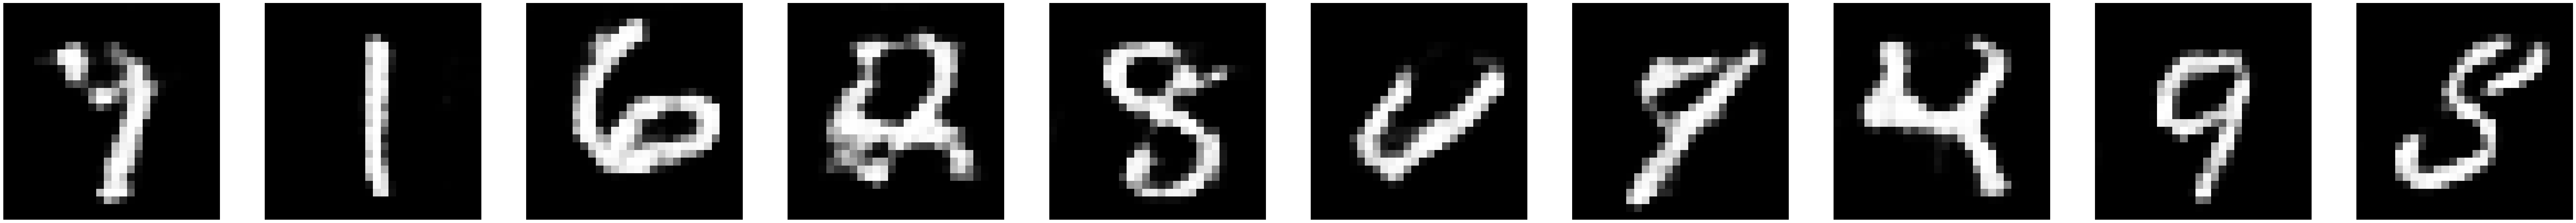

In [ ]:
input_distribution_size = 100
learning_rate = 1e-4
batch_size = 256
num_epochs = 50

generator = Generator()
discriminator = Discriminator()
noise = NoiseGenerator(input_distribution_size)
d_optim = tf.optimizers.Adam(learning_rate)
g_optim = tf.optimizers.Adam(learning_rate)

train_step = train_step_template(
    generator=generator,
    discriminator=discriminator,
    noise=noise,
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_f=w_discriminator_loss,
    g_loss_f=w_generator_loss,
)

gen_step = gen_step_template(
    generator=generator,
    noise=noise
)

train(
    train_step=train_step, 
    gen_step=gen_step,
    batch_size=batch_size,
    epochs=num_epochs
)

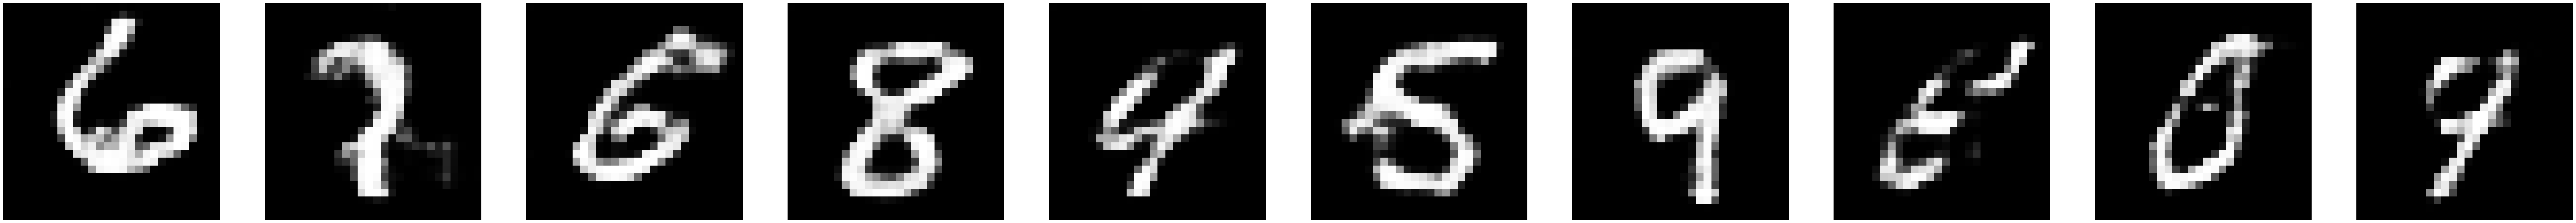

In [ ]:
one_input = tf.random.uniform([10, 100], -1, 1)
one_output = generator(one_input , False)

show_images(one_output)

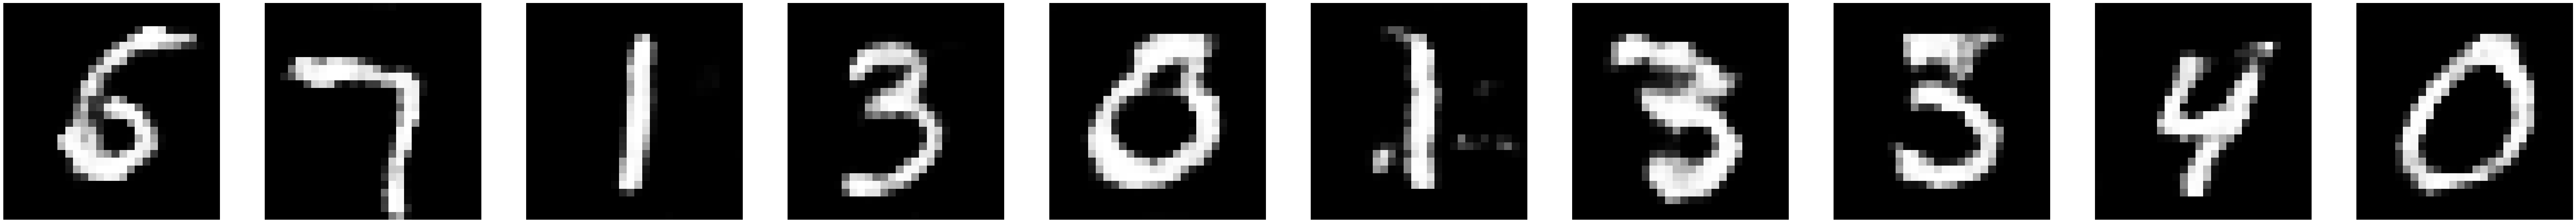

In [ ]:
two_input = tf.random.uniform([10, 100], -1, 1)
two_output = generator(two_input , False)

show_images(two_output)

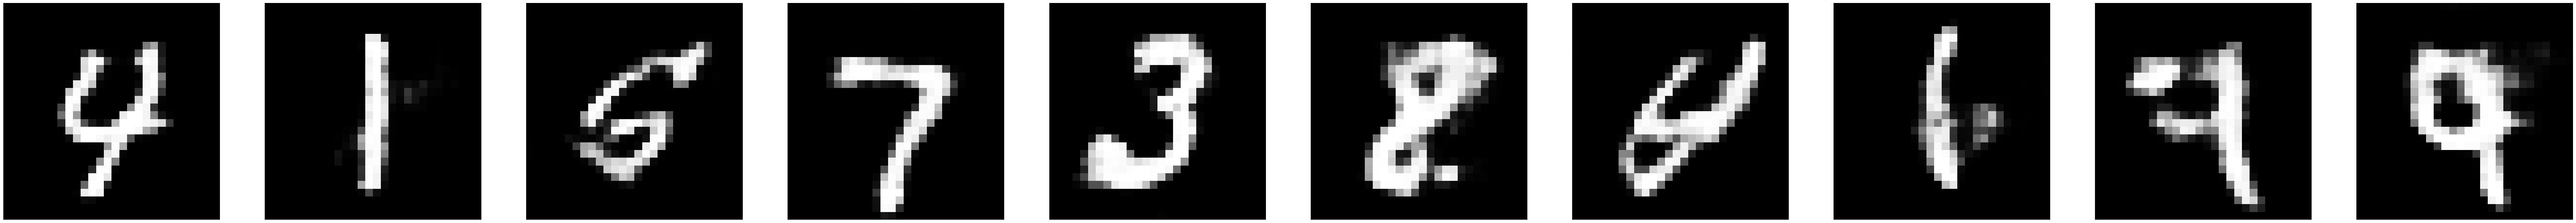

In [ ]:
three_input = tf.random.uniform([10, 100], -1, 1)
three_output = generator(three_input , False)

show_images(three_output)

In [ ]:
num_interp = 20

def interpolate(x, y):
  ret = [x + (y - x)* i/num_interp for i in range(num_interp)]
  return tf.stack(ret)

eight, three, seven = one_input[3], two_input[3], three_input[3], 
steps_outputs_1 = generator(interpolate(eight, three), False)
steps_outputs_2 = generator(interpolate(three, seven), False)

steps_outputs = tf.concat([steps_outputs_1, steps_outputs_2], 0)

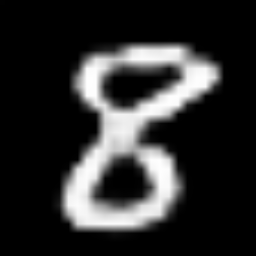

In [ ]:
show_gif(steps_outputs)